## В этом соревновании мы предсказываем рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачиваем работу с pandas
* Учимся работать с Kaggle Notebooks
* Делаем предобработку данных различного типа
* Учимся работать с пропущенными данными (Nan)
* Знакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
from numpy import nan # нужно для корректной десериализации и мапинга словарей к nan
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%matplotlib inline

pd.set_option("display.max_rows", 250)
pd.set_option("display.max_columns", 250)

# Set dots per inch to 300, very high quality images
# plt.rcParams['figure.dpi'] = 300

# Enable autolayout
# plt.rcParams['figure.autolayout'] = True

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Функции

In [4]:
# Создадим функцию для определения границ выбросов.
def find_IQR(data, column):
    perc_25 = data[column].quantile(0.25, interpolation="midpoint")
    perc_75 = data[column].quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print('Q1: {}'.format(perc_25), 'Q3: {}'.format(perc_75), 'IQR: {}'.format(IQR),
          'Граница выбросов: [{a},{b}]'.format(a=perc_25 - 1.5*IQR, b=perc_75 + 1.5*IQR), sep='\n')

    
# Вспомогательная функция для расчета и визуализации границ выбросов.
def show_IQR(pd_dataset, column_name, bins_n=10):
    """ 
   Вспомогательная функция для расчета и визуализации границ выбросов.
   на входе датасет, наименование столбца (признака) и количество столбиков гистограмы

   Выводит расчитанные параметры квантилей и гистограммы распределения и boxplot
    """
    data_column = pd_dataset[column_name]
    perc_25 = data_column.quantile(0.25, interpolation="midpoint")
    perc_75 = data_column.quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print(f'Q1: {perc_25}\nQ3: {perc_75}\nIQR: {IQR}',
          f'\nГраница выбросов: [{perc_25 - 1.5*IQR}, {perc_75 + 1.5*IQR}]')
    
    # гистограмма распределения: 
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.distplot(data_column.values, bins=bins_n, color='#50248f')
    plt.title(column_name + ' Distribution\n', fontsize=15)
    plt.xlabel(column_name)
    plt.ylabel('Quantity (frequency)')

    # boxplot: 
    plt.subplot(122)
    sns.boxplot(data_column.values, color='#38d1ff')
    plt.title(column_name + ' Distribution\n', fontsize=15)
    plt.xlabel(column_name)
    return 0
    
    
# определим функцию для быстрого построения боксплотов по всему датасету
def get_boxplot(data, column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='Rating',
                data=data, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def clean_name(val):
    if pd.isnull(val) == True: return 'Other'
    val = val.strip("[]")
    val = val.replace("\''", "")
    val = val.split(", ")
    return val


# заполняем пропущенные значения количества отзывов
def number_of_reviews(input_df):
    input_df.standard_ranking = round(input_df.standard_ranking, 2)
    input_df['rev_number'] = input_df.groupby(['standard_ranking'])['rev_number'].apply(lambda x: x.fillna(x.mean()))
    return input_df


def edit_number_of_reviews(df):
    # all about number_of_reviews
    # df = input_df.copy()
    scaler = StandardScaler()
    
    # средний ранкинг для каждого города
    mean_per_city = df.groupby('city')['rev_number'].mean()
    df['mean_Number_of_Reviews_per_city'] = df['city'].apply(lambda x: mean_per_city[x])

    #  масмимальный ранкинг для каждого города
    max_per_city = df.groupby('city')['rev_number'].max()
    df['max_Number_of_Reviews_per_city'] = df['city'].apply(lambda x: max_per_city[x])

    # стандартизация
    df['stand_Number_of_Reviews'] = (df['ranking'] - df['mean_Number_of_Reviews_per_city']) / df['max_Number_of_Reviews_per_city']
    
    # количество отзывов на каждого человека в городе
    try:
        df['reviews_per_each_person'] = df['rev_number'] / df['population']
    except:
        pass

    # среднее количество отзывов по городам
    reviews_per_city = df.groupby(by='city')['rev_number'].mean()
    df['reviews_per_city'] = df['city'].apply(lambda x: reviews_per_city[x])
    
    try:
        df['reviews_per_each_person'] = scaler.fit_transform(df[['reviews_per_each_person']])
    except:
        pass
    
    return df


def show_chained_rest(data):
    # Create a list with restaurants which might be in chain
    chained_rest_list = list(data['rest_id'].value_counts()[data['rest_id'].value_counts() > 1].index)
    
    # If it is in chain, we add in a new column the identificator '1', otherwise '0
    data['chained_rest'] = data[data['rest_id'].isin(chained_rest_list)]['rest_id'].apply(lambda x: 1)
    data['chained_rest'] = data['chained_rest'].fillna(0)
    
    
def show_duplicated_id(data):
    # добавим флаг, если id_ta встречается более 1 раза
    duplicated_id = list(data['id_ta'].value_counts()[data['id_ta'].value_counts() > 1].index)
    
    # If it is duplicated, we add in a new column the identificator '1', otherwise '0'
    data['dupl_id'] = data[data['id_ta'].isin(duplicated_id)]['id_ta'].apply(lambda x: 1)
    data['dupl_id'] = data['dupl_id'].fillna(0)
    
    
# Распределение Ranking и Raiting похожи. Когда рестораны с самым высоким Ranking, получают 4-4.5
# Создадим признак, который на основании Ranking вычисляет значение Rating
# Введем новую переменную, которая будет сопоставлять ранкинг количеству ресторанов в городе.
def ranking_normalize(data):
    reCount = data.city.value_counts()
    restCount = dict(reCount)
    data['rest_count'] = data['city'].map(restCount)
    
    # Нормализуем данные так, что бы ранг ресторана не зависил от количества ресторанов в city.
    mean_per_city = data.groupby('city')['ranking'].mean()
    data['mean_ranking_per_city'] = data['city'].apply(lambda x: mean_per_city[x])
    max_per_city = data.groupby('city')['ranking'].max()
    data['max_ranking_per_city'] = data['city'].apply(lambda x: max_per_city[x])
    data['standard_ranking'] = (data['ranking'] - data['mean_ranking_per_city']) / data['max_ranking_per_city']
    data.drop(['mean_ranking_per_city', 'max_ranking_per_city'], axis = 1, inplace=True)
    

In [5]:
# словарь превращения цен в числовые признаки. Медиана по всем городам - 2, так что заменим пропуски двойкой
price_range_dict = {
    '$': 1,
    '$$ - $$$': 2,
    '$$$$': 3,
    nan: 2,
}

# является ли город столицей
is_capital_dict = {
    'Paris': 1,
    'Stockholm': 1,
    'London': 1,
    'Berlin': 1,
    'Munich': 0,
    'Oporto': 0,
    'Milan': 0,
    'Bratislava': 1,
    'Vienna': 1,
    'Rome': 1,
    'Barcelona': 0,
    'Madrid': 1,
    'Dublin': 1,
    'Brussels': 1,
    'Zurich': 0,
    'Warsaw': 1,
    'Budapest': 1,
    'Copenhagen': 1,
    'Amsterdam': 1,
    'Lyon': 0,
    'Hamburg': 0,
    'Lisbon': 1,
    'Prague': 1,
    'Oslo': 1,
    'Helsinki': 1,
    'Edinburgh': 1,
    'Geneva': 0,
    'Ljubljana': 1,
    'Athens': 1,
    'Luxembourg': 1,
    'Krakow': 0,
}

# какой стране принадлежит город
country_dict = {
    'Paris': 'France',
    'Stockholm': 'Sweden',
    'London': 'United Kingdom',
    'Berlin': 'Germany',
    'Munich': 'Germany',
    'Oporto': 'Portugal',
    'Milan': 'Italy',
    'Bratislava': 'Slovakia',
    'Vienna': 'Austria',
    'Rome': 'Italy',
    'Barcelona': 'Spain',
    'Madrid': 'Spain',
    'Dublin': 'Ireland',
    'Brussels': 'Belgium',
    'Zurich': 'Switzerland',
    'Warsaw': 'Poland',
    'Budapest': 'Hungary',
    'Copenhagen': 'Denmark',
    'Amsterdam': 'Netherlands',
    'Lyon': 'France',
    'Hamburg': 'Germany',
    'Lisbon': 'Portugal',
    'Prague': 'Chechia',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Edinburgh': 'United Kingdom',
    'Geneva': 'Switzerland',
    'Ljubljana': 'Slovenia',
    'Athens': 'Greece',
    'Luxembourg': 'Luxemburg',
    'Krakow': 'Poland'
}

# численность по городам с Википедии
city_pop_dict = {
    'Paris': 2_187_526,
    'Stockholm': 975_551,
    'London': 8_982_000,
    'Berlin': 3_769_000,
    'Munich': 1_472_000,
    'Oporto': 214_349,
    'Milan': 1_352_000,
    'Bratislava': 424_428,
    'Vienna': 1_897_000,
    'Rome': 2_873_000,
    'Barcelona': 5_575_000,
    'Madrid': 6_642_000,
    'Dublin': 1_388_000,
    'Brussels': 174_383,
    'Zurich': 402_762,
    'Warsaw': 1_708_000,
    'Budapest': 1_752_000,
    'Copenhagen': 602_481,
    'Amsterdam': 821_752,
    'Lyon': 513_275,
    'Hamburg': 1_845_000,
    'Lisbon': 504_718,
    'Prague': 1_309_000,
    'Oslo': 681_067,
    'Helsinki': 631_695,
    'Edinburgh': 482_005,
    'Geneva': 499_480,
    'Ljubljana': 279_631,
    'Athens': 664_046,
    'Luxembourg': 124_528,
    'Krakow': 762_508
}

# ВВП по странам
# source - https://en.wikipedia.org/wiki/List_of_sovereign_states_in_Europe_by_GDP_(PPP)_per_capita
country_gdp_dict = {
    'Paris': 45_454,
    'Stockholm': 52_477,
    'London': 44_288,
    'Berlin': 53_571,
    'Munich': 53_571,
    'Oporto': 33_131,
    'Milan': 40_066,
    'Bratislava': 32_184,
    'Vienna': 55_406,
    'Rome': 40_066,
    'Barcelona': 38_143,
    'Madrid': 38_143,
    'Dublin': 89_383,
    'Brussels': 50_114,
    'Zurich': 68_340,
    'Warsaw': 33_739,
    'Budapest': 32_434,
    'Copenhagen': 57_781,
    'Amsterdam': 57_101,
    'Lyon': 45_454,
    'Hamburg': 53_571,
    'Lisbon': 33_131,
    'Prague': 40_293,
    'Oslo': 64_856,
    'Helsinki': 49_334,
    'Edinburgh': 44_288,
    'Geneva': 68_340,
    'Ljubljana': 38_506,
    'Athens': 29_045,
    'Luxembourg': 112_875,
    'Krakow': 33_739
}

# индекс покупательской способности согласно рейтингу Numbeo (2018)
purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,
    'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Oporto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

# Туристическая привлекательность.
# Место города в рейтинге топ-100 городов посещения в 2018 году (так как датасет устаревший)
# Источник - Euromonitor international

# Так как не все города входят в топ-100, то города делим на группы:
# 1 - место 1-25
# 2 - место 26-50
# 3 - место 51-75
# 4 - место 76-100
# 5 - место выше 100
tourist_attract = {
    'London' : 1,
    'Paris' : 1,
    'Madrid' : 2,
    'Barcelona' : 2,
    'Berlin' : 2,
    'Milan' : 5,
    'Rome' : 1,
    'Prague' : 1,
    'Lisbon' : 3,
    'Vienna' : 2,
    'Amsterdam' : 1,
    'Brussels' : 3,
    'Hamburg' : 5,
    'Munich' : 3,
    'Lyon' : 5,
    'Stockholm' : 4,
    'Budapest' : 3,
    'Warsaw' : 3,
    'Dublin' : 5,
    'Copenhagen' : 3,
    'Athens' : 2,
    'Edinburgh' : 5, 
    'Zurich' : 5,
    'Oporto' : 4,
    'Geneva' : 5, 
    'Krakow' : 3, 
    'Oslo' : 5, 
    'Helsinki' : 5,
    'Bratislava' : 5,
    'Luxembourg' : 5,
    'Ljubljana' : 5
}

local_cuisine_by_country = {
        'United Kingdom': ['British','Scottish'],
        'Spain': ['Spanish'],
        'France': ['French','Central European'], 
        'Italy': ['Italian','Central European'],
        'Germany': ['Dutch','German','Central European'],
        'Portugal': ['Portuguese'],
        'Chechia': ['Czech','Eastern European'],
        'Poland':['Polish','Eastern European'],
        'Austria': ['Austrian','Central European'],
        'Netherlands':['Scandinavian'],
        'Belgium': ['Belgian','Eastern European'],
        'Switzerland':['Swiss','Central European'],
        'Sweden':['Scandinavian'],
        'Hungary':['Hungarian','Eastern European'],
        'Ireland':['Irish'],
        'Denmark':['Scandinavian'],
        'Greece':['Greece'],
        'Norway':['Scandinavian'],
        'Finland':['Scandinavian'],
        'Slovakia':['Eastern European'],
        'Luxemburg':['Eastern European'],
        'Slovenia':['Slovenian','Eastern European']
}

cuisine_origin_groups = {
    'european': ['Italian','French','Spanish','Swiss','Belgian','Dutch','Austrian','Czech','Greek','German','Portuguese','Central European','Spanish','Mediterranean', 'European', 'Pizza'],
    'uk': ['British','Scottish','Welsh','Irish'],
    'scandinavian': ['Scandinavian','Norwegian','Balti','Swedish','Danish'],
    'east_europe':['Russian','Latvian','Romanian','Croatian','Slovenian','Albanian','Ukrainian','Hungarian','Polish','Eastern European'],
    'asian': ['Fujian','Central Asian','Taiwanese','Tibetan','Korean','Vietnamese','Thai','Asian','Singaporean', 'Indonesian', 'Mongolian', 'Uzbek', 'Yunnan','Xinjiang','Minority Chinese','Chinese'],
    'india':['Vegetarian Friendly', 'Indian', 'Sri Lankan', 'Nepali'],
    'japanese':['Sushi', 'Japanese'],
    'international': ['International', 'Fusion'],
    'colonial': ['Native American', 'American', 'Central American', 'Cajun & Creole', 'Canadian', 'Hawaiian','Australian','Jamaican', 'New Zealand', 'Polynesian'],
    'mideast_and_africa': ['Middle Eastern', 'Kosher', 'Israeli', 'Lebanese', 'Moroccan', 'Halal', 'African', 'Turkish', 'Tunisian', 'Egyptian', 'Arabic', 'Ethiopian', 'Afghani'],
    'caucasus': ['Armenian', 'Caucasian', 'Georgian', 'Azerbaijani'],
    'latam': ['Ecuadorean','Chilean','Colombian','Venezuelan','Peruvian','Brazilian','Argentinean','Latin', 'South American', 'Mexican', 'Salvadoran']
}
cuisine_specialization = {
    'drinks': ['Brew Pub','Wine Bar','Pub','Bar'],
    'general': ['Fast Food', 'Street Food', 'Cafe', 'Grill','Barbecue', 'Pizza', 'Diner', 'Soups', 'Fusion'],
    'specialty':['Gastropub','Delicatessen','Seafood', 'Sushi', 'Steakhouse'],
    'lifestyle': ['Vegetarian Friendly','Vegan Options','Gluten Free Options','Healthy', 'Halal', 'Contemporary']
}
regional_cusines = {'european', 'asian', 'american', 'colonial', 'mideast_and_africa', 'latam', 'caucasus'}
local_cuisines = {'France': ['French'],
 'Sweden': ['Swedish','Scandinavian'],
 'United Kingdom': ['British', 'Scottish', 'Welsh'],
 'Germany': ['German', 'Dutch'],
 'Portugal': ['Portuguese'],
 'Italy': ['Italian', 'Pizza'],
 'Slovakia': [],
 'Austria': ['Dutch','Austrian'],
 'Italy': ['Italian', 'Pizza'],
 'Spain': ['Spanish'],
 'Ireland': ['Irish'],
 'Belgium': ['Belgian'],
 'Switzerland':['Swiss'],
 'Poland': ['Polish','Eastern European'],
 'Hungary': ['Hungarian','Eastern European'],
 'Denmark': ['Danish','Scandinavian'],
 'Netherlands': [],
 'Chechia': ['Czech'],
 'Norway': ['Scandinavian','Norwegian'],
 'Finland': ['Scandinavian'],
 'Slovenia': ['Slovenian'],
 'Greece': ['Greek'],
 'Luxemburg': []
}

In [6]:
def show_price_range(data):
    # заменим '$, $$-$$$, $$$$' на числовые признаки
    price_range_dict = {
        '$': 1,
        '$$ - $$$': 2,
        '$$$$': 3
    }

    data['price_range'].replace(price_range_dict, inplace=True)

    # заполним пропущенные значения - медианой по выборке
    data['price_range'] = data['price_range'].fillna(data.groupby('city')['price_range'].transform('median'))
    
    
def show_city_dict(data):
    # добавим столбец is_capital, в котором отметим те записи, которые сделаны в ресторанх город-столиц
    data['is_capital'] = data['city'].map(is_capital_dict)

    # добавить признак country - он пригодится когда будем рабтать с локальными кухнями
    data['country'] = data['city'].map(country_dict)

    # добавим столбец "Численнность населения городов" с Wiki
    data['population'] = data['city'].map(city_pop_dict)

    # добавим столбец "Валовый внутренний продукт" по странам, соответствующим городам с Wiki
    # например, Париж -> Франция -> GDP (PPP) per capita = 45_454 (2020)
    # source - https://en.wikipedia.org/wiki/List_of_sovereign_states_in_Europe_by_GDP_(PPP)_per_capita
    data['country_gdp'] = data['city'].map(country_gdp_dict)

    # Признак - индекс покупательской способности согласно рейтингу Numbeo (2018)
    data['purchasing_power'] = data['city'].map(purchasing_power_index)

    # Добавим признак туристическая привлекательность.
    data['tourists'] = data.city.map(tourist_attract)
    
    
# Let's sort cities by most common in dataset. Rest of them we call as 'Other'
# To do so, create a new column 'new_city'.
# The column 'city' we will use further and then drop it
def city_list_shorter(data):
    all_cities = data['city'].value_counts().index
    data['new_city'] = data['city']

    # Create a top Cites list (more than 70% in Dataset)
    top_cities_list = data['new_city'].value_counts()[
        data['new_city'].value_counts() > np.percentile((data['new_city'].value_counts().values), 70)].index.tolist()

    cities_to_drop = list(set(all_cities)-set(top_cities_list))
    data.loc[data['new_city'].isin(cities_to_drop), 'new_city'] = 'Other'
    
    
def most_common_cuisines(data):
    top_10_cuisine = []
    top_10_cuisine = data.explode('cuisine_style')['cuisine_style'].value_counts()[
        data.explode('cuisine_style')['cuisine_style'].value_counts() >= 3786].index.tolist()
    data['most_common_cuisine'] = 0
    for i in range(len(data)):
        for cuis in top_10_cuisine:
            if cuis in data['cuisine_style'][i]:
                data['most_common_cuisine'][i] = 1
                break
            else:
                pass


def top_unique_cuisines(data):
    top_unique_cuisine = []
    top_unique_cuisine = data.explode('cuisine_style')['cuisine_style'].value_counts()[
        data.explode('cuisine_style')['cuisine_style'].value_counts() <= 4].index.tolist()
    data['top_unique_cuisine'] = 0
    for i in range(len(data)):
        for cuis in top_unique_cuisine:
            if cuis in data['cuisine_style'][i]:
                data['top_unique_cuisine'][i] = 1
                break
            else:
                pass



# добавим флаг для ресторанов, в которых есть вегетарианская кухня
def show_veget(data):
    veget_cuisine = ['Vegetarian Friendly', 'Healthy', 'Vegan Options', 'Gluten Free Options']

    data['veget_cuisine'] = 0
    for i in range(len(data)):
        for cuis in veget_cuisine:
            if cuis in data['cuisine_style'][i]:
                data['veget_cuisine'][i] = 1
                break
            else:
                pass
            
            
# добавим флаг для ресторанов с фаст- и джанк-фудом
def show_junk_food(data):
    pop_cuisine = ['Cafe','Grill','International','Mediterranean','Fast Food','Pizza','Pub','Sushi']

    data['pop_cuisine'] = 0
    for i in range(len(data)):
        for cuis in pop_cuisine:
            if cuis in data['cuisine_style'][i]:
                data['pop_cuisine'][i] = 1
                break
            else:
                pass
            
            
# добавим флаг для ресторанов с местной кухней
def show_local_food(data):   
    data['local_cuisine'] = 0
    for i in range(len(data)):
        current_country = data.country[i]
        for cuis in local_cuisine_by_country[current_country]:
            if cuis in data['cuisine_style'][i]:
                data['local_cuisine'][i] = 1
                break
            else:
                pass
            
            
def fix_revs_outs(data, edge):
    # создадим новый признак под те рестораны, где кол-во отзывов характеризуется как выброс
    data['many_revs'] = data['rev_number'].apply(lambda x: 1 if x > edge else 0)

    # Давайте заменим эти значения на edge.
    data['rev_number'] = data['rev_number'].apply(lambda x: edge if x > edge else x)
    
    
def review_dt_extract(data):
    pattern = re.compile("\d+\/\d+\/\d+")
    data['review_date'] = data['reviews'].apply(pattern.findall)

    # отсеиваем случаи, когда дата есть в комментарии
    data['review_date'] = data['review_date'].apply(lambda x: [x[-2], x[-1]] if len(x)>=3 else x)

    # случаи с одной датой и с двумя датами
    data['review_date_1'] = data['review_date'].apply(lambda x: x[0] if len(x)>=1 else None)
    data['review_date_2'] = data['review_date'].apply(lambda x: x[1] if len(x)==2 else None)

    # преобразуем к типу datetime
    data['review_date_1'] = pd.to_datetime(data['review_date_1'])
    data['review_date_2'] = pd.to_datetime(data['review_date_2'])
    
    
def fix_last_rev_outs(data, edge):
    # создадим новый признак под те рестораны, где время с последнего отзыва характеризуется как выброс
    data['no_recent_revs'] = data['days_from_last_rev'].apply(lambda x: 1 if x > edge else 0)

    # Давайте заменим эти значения на edge.
    data['days_from_last_rev'] = data['days_from_last_rev'].apply(lambda x: edge if x > edge else x)
    
    # fill missing values
    data['days_from_last_rev'] = data['days_from_last_rev'].fillna(data.groupby('city')['days_from_last_rev'].transform('median'))
    
    
def fix_rev_freq_outs(data, edge):
    # создадим новый признак под те рестораны, где время между отзывами характеризуется как выброс
    data['very_seldom_revs'] = data['review_freq'].apply(lambda x: 1 if x > edge else 0)

    # Давайте заменим эти значения на edge.
    data['review_freq'] = data['review_freq'].apply(lambda x: edge if x > edge else x)

    # заполнить пустые значения
    data['review_freq'] = data['review_freq'].fillna(data.groupby('city')['review_freq'].transform('median'))
    
    
def show_month_year(data):
    # выделим в отдельные столбцы месяца и годы
    data['rev_m1'] = pd.to_datetime(data['review_date_1']).dt.month
    data['rev_m2'] = pd.to_datetime(data['review_date_2']).dt.month
    data['rev_y1'] = pd.to_datetime(data['review_date_1']).dt.year
    data['rev_y2'] = pd.to_datetime(data['review_date_2']).dt.year

    # заполним пропуски
    data['rev_m1'] = data['rev_m1'].fillna(data.groupby('city')['rev_m1'].transform('median'))
    data['rev_m2'] = data['rev_m2'].fillna(data.groupby('city')['rev_m2'].transform('median'))
    data['rev_y1'] = data['rev_y1'].fillna(data.groupby('city')['rev_y1'].transform('median'))
    data['rev_y2'] = data['rev_y2'].fillna(data.groupby('city')['rev_y2'].transform('median'))
    
    
def show_reviews_and_len(data):
    # сперва выпишем ревью отдельно
    data['review_1'] = data['reviews'].str.findall(r"'([\w\s]*)'").str[0]
    data['review_2'] = data['reviews'].str.findall(r"'([\w\s]*)'").str[1]

    # Create a column which indicate that review is not avaliable
    data['empty_rev1'] = data['review_1'].isnull().astype('uint8')
    data['empty_rev2'] = data['review_2'].isnull().astype('uint8')

    # вычислим длину отзыва в символах
    data['review_1_len'] = data.review_1.str.len()
    data['review_2_len'] = data.review_2.str.len()

    # заполним пропуски средними по городам
    data['review_1_len'] = data['review_1_len'].fillna(data.groupby('city')['review_1_len'].transform('mean'))
    data['review_2_len'] = data['review_2_len'].fillna(data.groupby('city')['review_2_len'].transform('mean'))
    
    
def show_good_bad_comms(data):
    # добавить переменные по наличие слов в отзывах: well, good, excellent, poor, bad, worse, best, but, friendly, nice, ok, great
    # without 'not'
    # .lower()
    check_words = ['well', 'good', 'excellent', 'poor', 'bad', 'worse', 'best', 'but', 'friendly', 'nice', 'ok', 'great', 'lovely']

    for word in check_words:
        data[word] = 0
        for i in range(len(data)):
            if word in data['reviews'][i].lower() and 'not' not in data['reviews'][i].lower():
                data.loc[i, word] = 1
            else:
                pass
            
            
# Добавим еще несколько переменных
def norm_reviews(input_df):
    df = input_df.copy()
    mean_rews_by_city = round((df.groupby(['city'])['rev_number'].sum() /
                               df.groupby(['city'])['ranking'].max()), 2)
    mean_rews = df.city.apply(lambda x: mean_rews_by_city[x])
    mean_rews.name = 'Mean_rews'
    df = pd.concat([df, mean_rews],axis=1)

    df['Rating_RevNr2'] = df.ranking * df['rev_number']+1
    df['Rating_RevNr'] = df.standard_ranking * df['rev_number']+1
    df['rel_numberOfRws'] = (df.standard_ranking)/(df.ranking)
    return df


# функция для стандартизации
def StandardScaler_column(df, d_col):
    scaler = StandardScaler()
    scaler.fit(df[[d_col]])
    return scaler.transform(df[[d_col]])


# функции для классификации кухонь
def cuisine_origin(cs):
    found_types = {}
    if 'international' in cs:
        return 'international'
    for cg, cuisines in cuisine_origin_groups.items():
        for c in cs:
            if c in cuisines:
                found_types[cg] = found_types.get(cg, 0) + 1
    if len(found_types) == 0:
        return 'no_origin'                
    if len(found_types.keys() & regional_cusines) > 1:
        return 'international'
    else:
        return sorted(found_types.items(), key=lambda item: item[1])[-1][0]

    
def cuisine_spec(cs):
    found_types = {}
    for cg, cuisines in cuisine_specialization.items():
        for c in cs:
            if c in cuisines:
                found_types[cg] = found_types.get(cg, 0) + 1
    if len(found_types) == 0:
        return 'no_spec'
    return sorted(found_types.items(), key=lambda item: item[1])[-1][0]


def is_local_cuisine(row):
    locs = local_cuisines[row['Country']]
    return 1 if set(locs) & set(row['Cuisine Style deserialized']) else 0

# DATA

In [7]:
os.listdir()

['pp-project-3.ipynb',
 '.ipynb_checkpoints',
 'kaggle',
 'requirements.txt',
 'submission.csv']

In [8]:
DATA_DIR = './kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [10]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [12]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [13]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [14]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [15]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [16]:
data2 = data.copy()
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

В датасете есть столбцы, в которых отсутствуют пропуски:

* Restaurant_id
* City
* Ranking
* Rating
* Reviews
* URL_TA
* ID_TA

В следующих столбцах датасета данные представлены в виде числовых значений:

* Ranking
* Rating
* Number of Reviews

Повысить точность прогнозов, которые делает модель, с помощью более тщательной подготовки данных. При подготовке датасета нужно будет не только избавиться от пропущенных (None) значений и нечисловых признаков, но и сгенерировать новые признаки (добавить в датафрейм новые столбцы) на основе информации, уже содержащейся в данных.

В исходном наборе данных всего три столбца содержат числовые данные, причём один из этих столбцов — это целевая переменная, значение которой должна предсказывать наша модель. Так что просто удалить все object-значения и считать задачу выполненной не получится. Для создания качественной модели нам сначала придётся очень основательно поработать со строковыми данными и извлечь из них как можно больше информации, которую можно представить в числовом виде.

In [17]:
# Rename columns removing spaces and substituting capital letters

data2.rename(columns={'Restaurant_id': 'rest_id',
                   'City': 'city',
                   'Cuisine Style': 'cuisine_style',
                   'Ranking': 'ranking',
                   'Rating': 'rating',
                   'Price Range': 'price_range',
                   'Number of Reviews': 'rev_number',
                   'Reviews': 'reviews',
                   'URL_TA': 'url_ta',
                   'ID_TA': 'id_ta'}, inplace=True)

In [18]:
data2.sample(5)

,rest_id,city,cuisine_style,ranking,price_range,rev_number,reviews,url_ta,id_ta,sample,rating
4427,id_4427,Berlin,['Vegetarian Friendly'],1368.0,$,23.0,"[['Zen out of Zen...', 'Outstanding'], ['09/16...",/Restaurant_Review-g187323-d11687378-Reviews-Z...,d11687378,0,0.0
5601,id_5601,London,"['Chinese', 'Asian', 'Fast Food']",14331.0,$,12.0,"[['Pancake rolls rule', 'Quick at tasty luncht...",/Restaurant_Review-g186338-d5816172-Reviews-Mr...,d5816172,0,0.0
49989,id_8887,London,['International'],8896.0,NaN,NaN,"[['I love this place!'], ['08/24/2015']]",/Restaurant_Review-g186338-d5550626-Reviews-Th...,d5550626,1,5.0
1531,id_1531,Munich,['Chinese'],2090.0,NaN,9.0,"[['Explosive Hot Pot in Munich!', 'A bit disap...",/Restaurant_Review-g187309-d12563916-Reviews-C...,d12563916,0,0.0
17919,id_333,Ljubljana,NaN,334.0,NaN,4.0,[['Modern equiped restaurant with Slovene and....,/Restaurant_Review-g274873-d12402906-Reviews-G...,d12402906,1,4.0


In [19]:
data2.reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

В нашем получившемся общем датасете мы видим 10 признаков (sample не считаем, так как это искуственный признак для дальнейшего разделения датасета). Три признака заполнены числовыми значениями, остальные номинативными. Что содержится в каждом из признаков посмотрим дальше, являются ли они категориальными и т.д. В некоторых признаках содержится достаточно большое количество пропусков. По условиям задания мы не можем удалять строки, так что будем заполнять пропуски и, возможно, создавать отдельный признак пропусков, так как отсуствия значения может быть также важной информацией для модели.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

rest_id - 0%
city - 0%
cuisine_style - 23%
ranking - 0%
price_range - 35%
rev_number - 6%
reviews - 0%
url_ta - 0%
id_ta - 0%
sample - 0%
rating - 0%


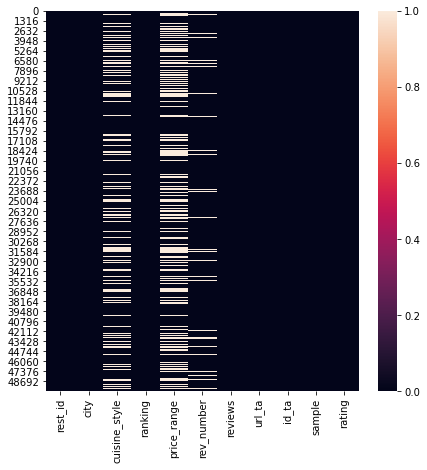

In [20]:
# Plot missing values
cols = data2.columns
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(data2[cols].isnull())

# Show in percents
for col in data2.columns:
    pct_missing = np.mean(data2[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

In [21]:
# посмотрим на кол-во пропусков, с которым предстоит работать

data2.isnull().sum()

rest_id              0
city                 0
cuisine_style    11590
ranking              0
price_range      17361
rev_number        3200
reviews              2
url_ta               0
id_ta                0
sample               0
rating               0
dtype: int64

['rest_id']
Не уверен, что данный признак будет полезен для модели. Однако визуально видна зависимость между данным признаком и признаком ranking. Посмотрим на корреляцию.

In [22]:
data2['rest_id'] = data2['rest_id'].apply(lambda x: float(x[3:]))
data2[['rest_id', 'ranking']].corr()

,rest_id,ranking
rest_id,1.00000,0.82509
ranking,0.82509,1.00000


Да, корреляция есть. В таком случае признак rest_id потом удалим. Пока оставим, может пригодиться для формирования новых признаков.

Обработка NAN и Обработка признаков У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, даже отсутствие информации может быть важным признаком!
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак.

In [23]:
# создадим флаги по записям, для которых отсутствуют сведения
data2['empty_rev_number'] = pd.isna(data2['rev_number']).astype('uint8')
data2['empty_cuisine'] = pd.isna(data2['cuisine_style']).astype('uint8')
data2['empty_price'] = pd.isna(data2['price_range']).astype('uint8')

data2['reviews'] = data2['reviews'].fillna('[[], []]')
data2['empty_reviews'] = (data2['reviews'] == '[[], []]').astype('float64')

In [24]:
for col in ['empty_rev_number', 'empty_cuisine', 'empty_price', 'empty_reviews']:
    display(data2[col].value_counts())

0    46800
1     3200
Name: empty_rev_number, dtype: int64

0    38410
1    11590
Name: empty_cuisine, dtype: int64

0    32639
1    17361
Name: empty_price, dtype: int64

0.0    41886
1.0     8114
Name: empty_reviews, dtype: int64

/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


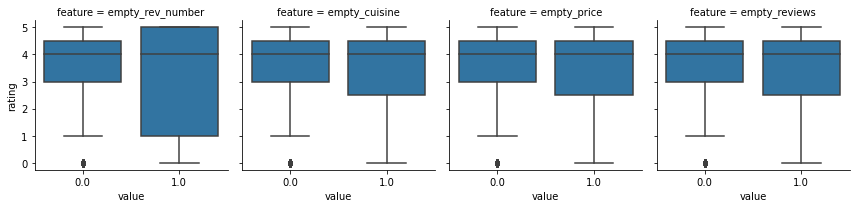

In [25]:
# Проверим распределение rating по отсутствующим признакам.

sns.FacetGrid(data2[['empty_rev_number',
                     'empty_cuisine',
                     'empty_price',
                     'empty_reviews',
                     'rating']].melt(
                         id_vars=["rating"],
                         var_name="feature",
                         value_name="value"), col="feature").map(sns.boxplot, "value", "rating")

In [26]:
# Пустые значения о кухнях заполним категорией Other.
data2['cuisine_style'] = data2['cuisine_style'].fillna("['Other']")

In [27]:
data2['cuisine_style'].value_counts()

['Other']                                                                                      11590
['Italian']                                                                                     1332
['French']                                                                                      1019
['Spanish']                                                                                      860
['French', 'European']                                                                           503
                                                                                               ...  
['Mediterranean', 'German', 'European', 'Vegetarian Friendly']                                     1
['European', 'Spanish', 'Fusion', 'Gluten Free Options']                                           1
['Italian', 'European', 'Gluten Free Options', 'Vegetarian Friendly']                              1
['Healthy', 'Asian', 'Thai', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']

In [28]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rest_id           50000 non-null  float64
 1   city              50000 non-null  object 
 2   cuisine_style     50000 non-null  object 
 3   ranking           50000 non-null  float64
 4   price_range       32639 non-null  object 
 5   rev_number        46800 non-null  float64
 6   reviews           50000 non-null  object 
 7   url_ta            50000 non-null  object 
 8   id_ta             50000 non-null  object 
 9   sample            50000 non-null  int64  
 10  rating            50000 non-null  float64
 11  empty_rev_number  50000 non-null  uint8  
 12  empty_cuisine     50000 non-null  uint8  
 13  empty_price       50000 non-null  uint8  
 14  empty_reviews     50000 non-null  float64
dtypes: float64(5), int64(1), object(6), uint8(3)
memory usage: 4.7+ MB


### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [29]:
data2.nunique(dropna=False)

rest_id             13094
city                   31
cuisine_style       10732
ranking             12975
price_range             4
rev_number           1574
reviews             41857
url_ta              49963
id_ta               49963
sample                  2
rating                 10
empty_rev_number        2
empty_cuisine           2
empty_price             2
empty_reviews           2
dtype: int64

In [30]:
# определим к какому типу данных относятся данные в каждом из столбцов датасета

for column in data2.columns:
    print(column, type(data2[column][0]))

rest_id <class 'numpy.float64'>
city <class 'str'>
cuisine_style <class 'str'>
ranking <class 'numpy.float64'>
price_range <class 'str'>
rev_number <class 'numpy.float64'>
reviews <class 'str'>
url_ta <class 'str'>
id_ta <class 'str'>
sample <class 'numpy.int64'>
rating <class 'numpy.float64'>
empty_rev_number <class 'numpy.uint8'>
empty_cuisine <class 'numpy.uint8'>
empty_price <class 'numpy.uint8'>
empty_reviews <class 'numpy.float64'>


В датасете отсутствуют столбцы, в которых данные представлены в виде списков

In [31]:
data2.describe()

,rest_id,ranking,rev_number,sample,rating,empty_rev_number,empty_cuisine,empty_price,empty_reviews
count,50000.000000,50000.000000,46800.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,3938.252580,3664.427520,124.471197,0.800000,3.194430,0.064000,0.231800,0.347220,0.162280
std,3597.493647,3700.092452,294.114345,0.400004,1.705453,0.244755,0.421986,0.476091,0.368711
min,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1111.000000,972.000000,9.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,2709.000000,2278.000000,33.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000
75%,5918.000000,5241.000000,115.000000,1.000000,4.500000,0.000000,0.000000,1.000000,0.000000
max,16422.000000,16444.000000,9660.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
for col in ['city', 'cuisine_style', 'reviews', 'url_ta', 'id_ta']:
    display(data2[col].describe())

count      50000
unique        31
top       London
freq        7193
Name: city, dtype: object

count         50000
unique        10732
top       ['Other']
freq          11590
Name: cuisine_style, dtype: object

count        50000
unique       41857
top       [[], []]
freq          8114
Name: reviews, dtype: object

count                                                 50000
unique                                                49963
top       /Restaurant_Review-g187514-d5617412-Reviews-Gr...
freq                                                      2
Name: url_ta, dtype: object

count        50000
unique       49963
top       d3748757
freq             2
Name: id_ta, dtype: object

In [33]:
data2.pivot_table(index='city', columns='price_range', values='rating', aggfunc='mean')

price_range,$,$$ - $$$,$$$$
city,,,
Amsterdam,3.170507,3.326196,3.231707
Athens,3.294444,3.544207,3.166667
Barcelona,3.255068,3.156951,3.543269
Berlin,3.286215,3.245851,3.767857
Bratislava,3.578947,3.052419,3.178571
Brussels,3.194118,3.116588,3.204082
Budapest,3.353333,3.208520,3.517857
Copenhagen,3.192308,3.120773,3.513514
Dublin,3.453642,3.196352,2.764706


Какие признаки можно считать категориальными?

К категориальным признакам можно отнести city. В дальнейшем попробуем обработать его как с помощью get_dummies, так и попробуем выделением топ-10 наиболее часто встречающихся городов и присвоения признака other остальным.

Аналогичные операции проведем с cuisine_style, но количество уникальных значений там значительно больше.

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [34]:
data2.sample(5)

,rest_id,city,cuisine_style,ranking,price_range,rev_number,reviews,url_ta,id_ta,sample,rating,empty_rev_number,empty_cuisine,empty_price,empty_reviews
48729,10065.0,London,"['Bar', 'British', 'Pub', 'Contemporary']",10074.0,$$ - $$$,56.0,"[['Beer outage', 'Fun night out with lots of d...",/Restaurant_Review-g186338-d733382-Reviews-Ele...,d733382,1,3.5,0,0,0,0.0
6793,6793.0,Madrid,['Mediterranean'],5541.0,$,33.0,"[['Want a great local restaurant. This is it',...",/Restaurant_Review-g187514-d5975929-Reviews-Re...,d5975929,0,0.0,0,0,0,0.0
13061,10255.0,Paris,"['Japanese', 'Sushi']",10257.0,$$ - $$$,34.0,"[['Very authentic sushi place', 'Must visit'],...",/Restaurant_Review-g187147-d780501-Reviews-Kil...,d780501,1,4.0,0,0,0,0.0
28596,429.0,Lisbon,"['American', 'Vegetarian Friendly']",430.0,$,62.0,"[['Good food and atmosphere', 'Hot dogs'], ['0...",/Restaurant_Review-g189158-d12002817-Reviews-F...,d12002817,1,4.5,0,0,0,0.0
22244,1653.0,Edinburgh,"['Cafe', 'British']",1659.0,$,35.0,"[['Average', ""It's ok!""], ['04/14/2017', '03/3...",/Restaurant_Review-g186525-d8530671-Reviews-De...,d8530671,1,3.0,0,0,0,0.0


## rest_id

In [35]:
# Проверяем уникальность признака rest_id. Есть повторения. 
data2['rest_id'].value_counts()

633.0      19
227.0      19
436.0      19
871.0      19
71.0       18
           ..
11467.0     1
10963.0     1
12286.0     1
16148.0     1
9913.0      1
Name: rest_id, Length: 13094, dtype: int64

Q1: 1111.0
Q3: 5918.0
IQR: 4807.0 
Граница выбросов: [-6099.5, 13128.5]


/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0

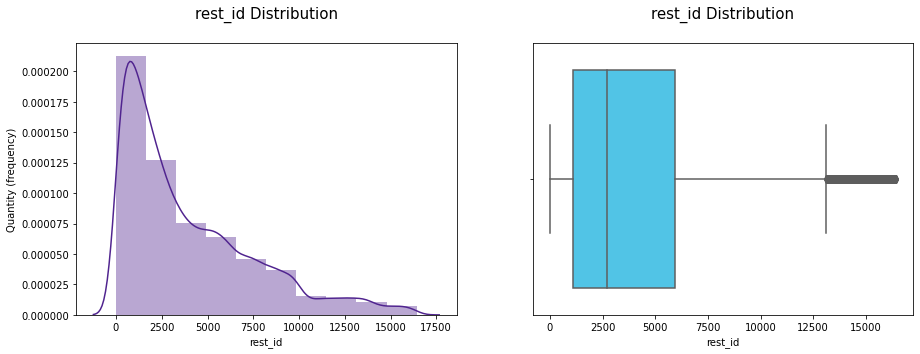

In [36]:
# Проверим распределение признака.
show_IQR(data2, "rest_id")

Text(0.5, 1.0, 'Распределие признака rest_id')

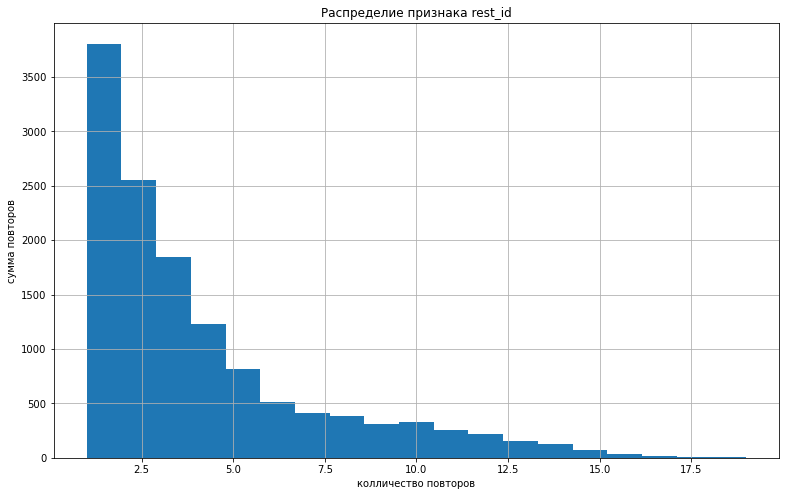

In [37]:
plt.rcParams['figure.figsize'] = (13,8)
ds = data2['rest_id'].value_counts().hist(bins=data2['rest_id'].value_counts().max())
ds.set_xlabel('колличество повторов')
ds.set_ylabel('сумма повторов')
ds.set_title('Распределие признака rest_id')

In [38]:
show_chained_rest(data2)

# Check
data2['chained_rest'].value_counts()

1.0    46193
0.0     3807
Name: chained_rest, dtype: int64

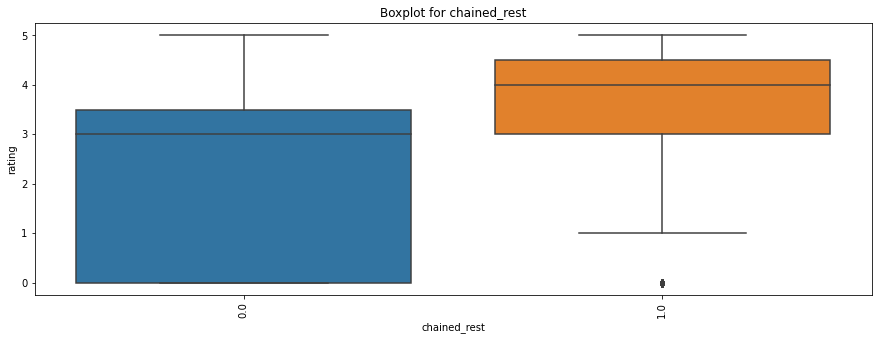

In [39]:
# Проверим распределение rating по признаку отнесения ресторана к сетевому.
column = 'chained_rest'
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x=column, y='rating',data=data2.loc[data2.loc[:, column].isin(data2.loc[:, column].value_counts().index[:])],ax=ax)
plt.xticks(rotation=90)
ax.set_title(f'Boxplot for {column}')
plt.show()

По признаку rest_id мы смогли определить, что в датасете есть одиночные рестораны и рестораны, входящие в сети.

## ID_TA

In [40]:
# Есть еще одна колонка, в которой есть уникальные id рестаранов.
data2['id_ta'].value_counts()

d3748757     2
d3161682     2
d987900      2
d2360290     2
d4600226     2
            ..
d11877378    1
d7370704     1
d7098361     1
d8490343     1
d5827085     1
Name: id_ta, Length: 49963, dtype: int64

In [41]:
# преобразуем в числовой признак
data2['id_ta'] = data2['id_ta'].apply(lambda x: float(x[1:]))

Q1: 2481490.0
Q3: 9797339.0
IQR: 7315849.0 
Граница выбросов: [-8492283.5, 20771112.5]


/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0

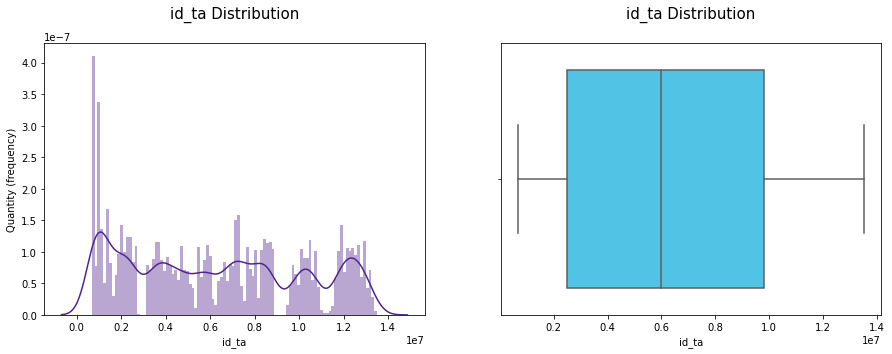

In [42]:
# Видно Несколько групп - на ID - точно не похоже.
show_IQR(data2, "id_ta", 100)

In [43]:
show_duplicated_id(data2)

# Check
data2['dupl_id'].value_counts()

0.0    49926
1.0       74
Name: dupl_id, dtype: int64

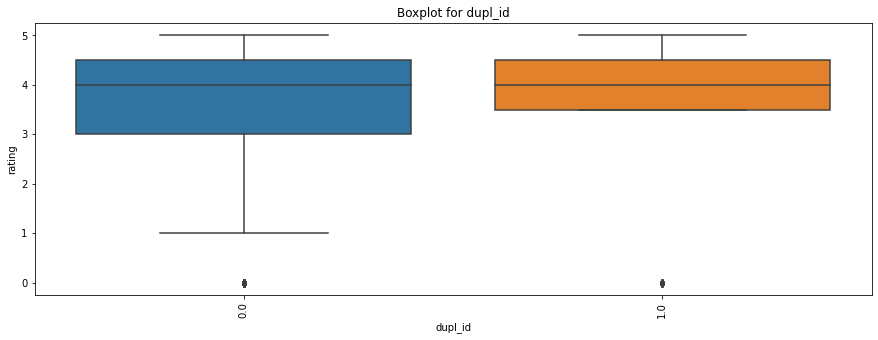

In [44]:
# Проверим распределение rating по признаку наличия дубликатов в ID_TA.
column = 'dupl_id'
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x=column, y='rating',data=data2.loc[data2.loc[:, column].isin(data2.loc[:, column].value_counts().index[:])],ax=ax)
plt.xticks(rotation=90)
ax.set_title(f'Boxplot for {column}')
plt.show()

При анализе признака нашли 74 ресторана с дублирующимися id_ta

## URL_TA

In [45]:
# Здесь тоже есть повторения, проверим как они сопостовляются со ссылками на рестораны.
data2['url_ta'].value_counts()

/Restaurant_Review-g187514-d5617412-Reviews-Green_Marta_Iii-Madrid.html                                   2
/Restaurant_Review-g187514-d3647024-Reviews-La_Zamorana-Madrid.html                                       2
/Restaurant_Review-g187514-d9877640-Reviews-Raku_Sushi-Madrid.html                                        2
/Restaurant_Review-g187514-d7337366-Reviews-Lady_Madonna-Madrid.html                                      2
/Restaurant_Review-g187514-d697406-Reviews-Al_Mounia-Madrid.html                                          2
                                                                                                         ..
/Restaurant_Review-g188590-d1504781-Reviews-Harmsen-Amsterdam_North_Holland_Province.html                 1
/Restaurant_Review-g187331-d5852565-Reviews-Mozart39-Hamburg.html                                         1
/Restaurant_Review-g187323-d11885856-Reviews-GLASWERK-Berlin.html                                         1
/Restaurant_Review-g187309-d

In [46]:
# Из таблицы видно, что мы имеем дело с дубликатами ресторанов.
# Причем значение Ranking у них не одинаковые.
data2[(data2['url_ta'].map(data2['url_ta'].value_counts()) == 2)].sort_values(by='id_ta')

,rest_id,city,cuisine_style,ranking,price_range,rev_number,reviews,url_ta,id_ta,sample,rating,empty_rev_number,empty_cuisine,empty_price,empty_reviews,chained_rest,dupl_id
38096,1209.0,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...",1210.0,$$ - $$$,341.0,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,697406.0,1,4.0,0,0,0,0.0,1.0,1.0
14578,1180.0,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...",1181.0,$$ - $$$,341.0,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,697406.0,1,4.0,0,0,0,0.0,1.0,1.0
15240,2406.0,Madrid,"['Italian', 'French', 'European']",2408.0,$$ - $$$,148.0,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,793170.0,1,4.0,0,0,0,0.0,1.0,1.0
46822,2487.0,Madrid,"['Italian', 'French', 'European']",2489.0,$$ - $$$,148.0,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,793170.0,1,4.0,0,0,0,0.0,1.0,1.0
18019,2361.0,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2363.0,$$ - $$$,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900.0,1,4.0,0,0,0,0.0,1.0,1.0
32998,2312.0,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2314.0,$$ - $$$,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900.0,1,4.0,0,0,0,0.0,1.0,1.0
28388,1229.0,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1231.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,1028622.0,1,4.0,0,0,0,0.0,1.0,1.0
4534,4534.0,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1253.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,1028622.0,0,0.0,0,0,0,0.0,1.0,1.0
7853,7853.0,Madrid,['Other'],2931.0,NaN,229.0,"[['Good Paella', 'Good enough. Nothing more'],...",/Restaurant_Review-g187514-d1235635-Reviews-Re...,1235635.0,0,0.0,0,1,1,0.0,0.0,1.0
46074,2973.0,Madrid,['Other'],2975.0,NaN,229.0,"[['Good Paella', 'Good enough. Nothing more'],...",/Restaurant_Review-g187514-d1235635-Reviews-Re...,1235635.0,1,3.5,0,1,1,0.0,1.0,1.0


In [47]:
# Дубликаты представлены в основном в Мадриде, но есть и в Варшаве.
data2[(data2['url_ta'].map(data2['url_ta'].value_counts()) == 2)].sort_values(by='id_ta').city.value_counts()

Madrid    70
Warsaw     4
Name: city, dtype: int64

In [48]:
# В признаке url_ta содержится информация о названии ресторана, о id_ta ресторана, а так же id города.
# Попробуем поменять значение признака.
data2['city_url'] = data2.url_ta.str.findall(r"g([\s\S]+?)-").str[0]
data2.pivot_table(index=['city', 'city_url'])

chained_rest   dupl_id  empty_cuisine  empty_price  \
city       city_url                                                       
Amsterdam  188590        0.971574  0.000000       0.147230     0.233236   
Athens     189400        0.971649  0.000000       0.192010     0.314433   
Barcelona  187497        0.974963  0.000000       0.231811     0.335199   
Berlin     187323        0.975970  0.000000       0.337153     0.464695   
Bratislava 1439609       0.000000  0.000000       0.000000     0.000000   
           274924        0.984169  0.000000       0.379947     0.538259   
Brussels   1068497       1.000000  0.000000       0.352941     0.352941   
           1136488       0.931818  0.000000       0.386364     0.477273   
           1136493       0.986301  0.000000       0.246575     0.301370   
           1136495       1.000000  0.000000       0.275862     0.413793   
           1136497       1.000000  0.000000       0.187500     0.375000   
           1136501       1.000000  0.000000       0.263158     0.368421   
           1156375       1.000000  0.000000       0.428571     0.571429   
           188644        0.972945  0.000000       0.218522     0.320499   
           1891930       1.000000  0.000000       0.500000     0.700000   
           947638        1.000000  0.000000       0.166667     0.250000   
           950777        0.958333  0.000000       0.583333     0.791667   
           950779        0.800000  0.000000       0.200000     0.600000   
           950780        1.000000  0.000000       0.200000     0.360000   
           950781        0.888889  0.000000       0.444444     0.444444   
           950782        1.000000  0.000000       0.500000     0.500000   
           950783        1.000000  0.000000       1.000000     1.000000   
           950784        1.000000  0.000000       0.214286     0.285714   
           950785        1.000000  0.000000       0.000000     0.000000   
           950786        1.000000  0.000000       0.454545     0.500000   
Budapest   274887        0.968658  0.000000       0.197845     0.315377   
Copenhagen 189541        0.975806  0.000000       0.243280     0.331989   
           806262        0.960000  0.000000       0.293333     0.400000   
Dublin     186605        0.977273  0.000000       0.157895     0.241627   
Edinburgh  186525        0.980900  0.000000       0.130969     0.197817   
           4049419       1.000000  0.000000       0.000000     0.000000   
Geneva     1096098       1.000000  0.000000       0.250000     0.375000   
           1190139       1.000000  0.000000       0.333333     0.500000   
           1203132       1.000000  0.000000       0.000000     0.142857   
           1572356       1.000000  0.000000       0.333333     0.333333   
           188057        0.968864  0.000000       0.188645     0.313187   
           1974645       0.750000  0.000000       0.333333     0.416667   
           3284927       1.000000  0.000000       0.000000     0.000000   
           4346525       0.833333  0.000000       0.500000     0.500000   
           6919449       1.000000  0.000000       1.000000     1.000000   
Hamburg    187331        0.980607  0.000000       0.438449     0.557336   
Helsinki   189934        0.987368  0.000000       0.214737     0.332632   
Krakow     274772        0.978339  0.000000       0.212996     0.319495   
Lisbon     189158        0.968427  0.000000       0.242259     0.341226   
Ljubljana  274873        0.990991  0.000000       0.148649     0.288288   
London     186338        0.734186  0.000000       0.168219     0.277631   
Luxembourg 190356        0.992218  0.000000       0.155642     0.280156   
           206535        1.000000  0.000000       0.166667     0.333333   
Lyon       1080936       1.000000  0.000000       0.000000     0.000000   
           1080937       1.000000  0.000000       0.500000     1.000000   
           1080938       0.954545  0.000000       0.545455     0.772727   
           1096044       1.000000  0.000000   

## Ranking

Q1: 972.0
Q3: 5241.0
IQR: 4269.0 
Граница выбросов: [-5431.5, 11644.5]


/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0

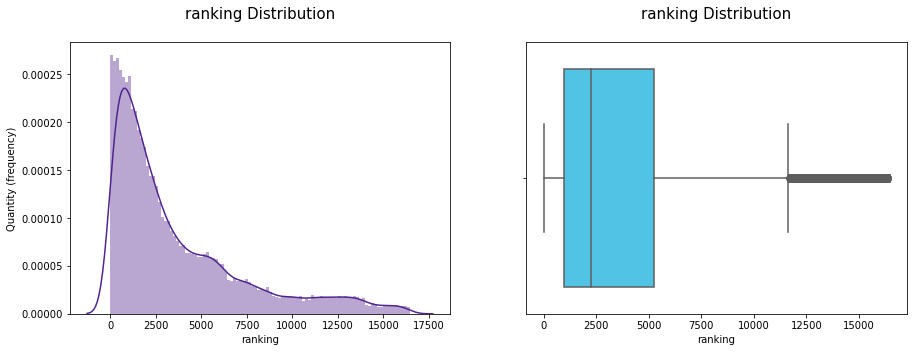

In [49]:
# Проверим распределение признака Ranking.
show_IQR(data2, "ranking", 100)

Ниже число - выше ранг. Он распределен между ресторанами в городе. Т.е. в каждом городе есть ресторан с наивысшим рангом, но не в каждом с большим числом.

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

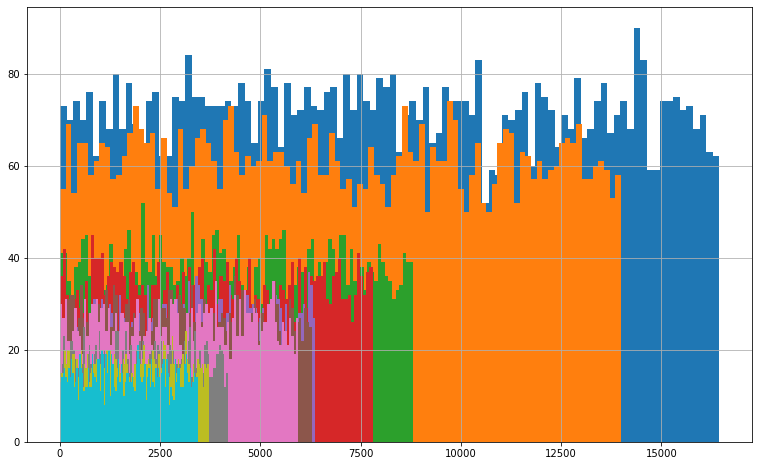

In [50]:
# На этом графике хорошо видно, что ranking нарямую зависит от колличества ресторанов в городе.
for x in (data2['city'].value_counts())[0:10].index:
    data2['ranking'][data2['city'] == x].hist(bins=100)
plt.show()

<Figure size 360x360 with 0 Axes>

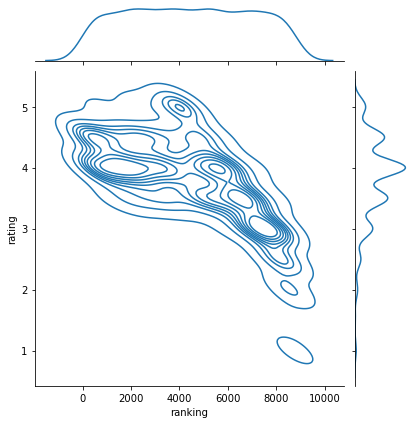

In [51]:
# Визуализируем распределение рейтинга по ранкам ресторанов в одном городе.
plt.figure(figsize = (5,5))
sns.jointplot(data = data2[(data2.city == 'Madrid') & (data2.rating > 0)], x = 'ranking', y = 'rating', kind = 'kde')

<Figure size 360x360 with 0 Axes>

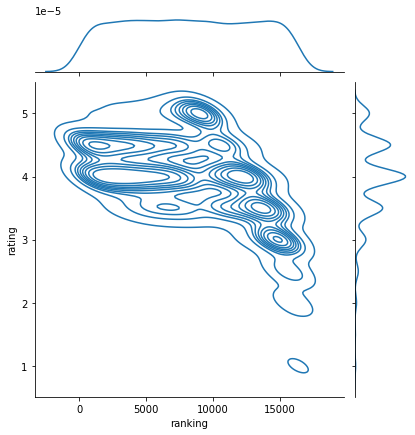

In [52]:
plt.figure(figsize = (5,5))
sns.jointplot(data = data2[(data2.city == 'London') & (data2.rating > 0)], x = 'ranking', y = 'rating', kind = 'kde')

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

In [53]:
ranking_normalize(data2)

# check
data2.sample(5)

,rest_id,city,cuisine_style,ranking,price_range,rev_number,reviews,url_ta,id_ta,sample,rating,empty_rev_number,empty_cuisine,empty_price,empty_reviews,chained_rest,dupl_id,city_url,rest_count,standard_ranking
10933,2073.0,Paris,"['French', 'Bar', 'Cafe', 'European', 'Pub']",2074.0,$$ - $$$,128.0,"[['Excellent food and atmosphere.', 'Great foo...",/Restaurant_Review-g187147-d1048529-Reviews-Le...,1048529.0,1,4.0,0,0,0,0.0,1.0,0.0,187147,6108,-0.347816
37966,204.0,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Healt...",205.0,$$ - $$$,798.0,"[['Good food, service a bit slow', 'Good Food ...",/Restaurant_Review-g187497-d1379335-Reviews-L_...,1379335.0,1,4.5,0,0,0,0.0,1.0,0.0,187497,3395,-0.471322
29561,1305.0,Vienna,"['Austrian', 'European']",1306.0,$,28.0,[['a quiet place to rest and while shopping......,/Restaurant_Review-g190454-d2073015-Reviews-Re...,2073015.0,1,4.0,0,0,0,0.0,1.0,0.0,190454,1443,-0.117676
16521,1908.0,Rome,"['Italian', 'Pizza', 'Seafood', 'Mediterranean...",1909.0,$$ - $$$,279.0,"[['nice loca italian restaurant', 'Our Go-To R...",/Restaurant_Review-g187791-d1464145-Reviews-Ri...,1464145.0,1,4.0,0,0,0,0.0,1.0,0.0,187791,2589,-0.178503
12366,894.0,Munich,"['American', 'Mediterranean', 'Barbecue', 'Tha...",902.0,$,6.0,"[['Amazing sandwiches!', 'Awesome Sandwich'], ...",/Restaurant_Review-g187309-d12845967-Reviews-J...,12845967.0,1,5.0,0,0,0,0.0,1.0,0.0,187309,1145,-0.169489


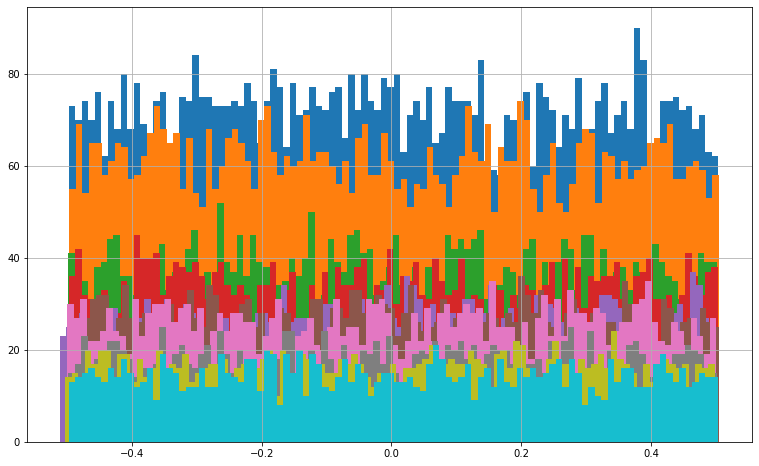

In [54]:
# посмотрим обновленое распределение для тех же городов
for x in (data2['city'].value_counts())[0:10].index:
    data2['standard_ranking'][data2['city'] == x].hist(bins=100)
plt.show()

Смещение устранено

## Price Range

Уровни цен обозначаются (от меньшего к большему): 1, 2-3, 4

In [55]:
show_price_range(data2)

# check
data2['price_range'].value_counts()

2.0    40402
1.0     7816
3.0     1782
Name: price_range, dtype: int64

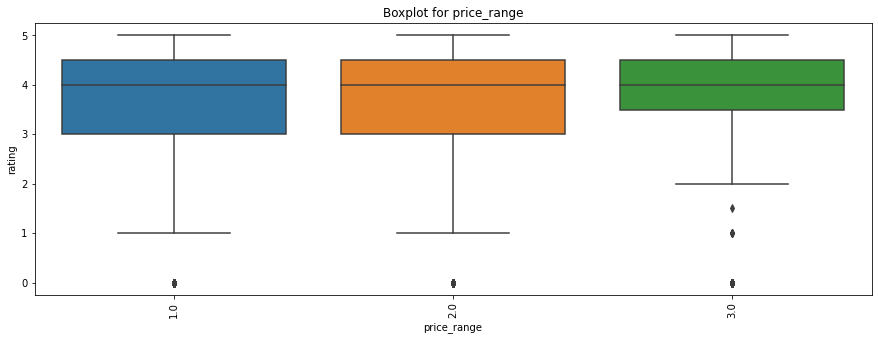

In [56]:
# Проверим распределение rating по признаку наличия дубликатов в ID_TA.
column = 'price_range'
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x=column, y='rating',data=data2.loc[data2.loc[:, column].isin(data2.loc[:, column].value_counts().index[:])],ax=ax)
plt.xticks(rotation=90)
ax.set_title(f'Boxplot for {column}')
plt.show()

In [57]:
data2[['price_range', 'rating']].corr()

,price_range,rating
price_range,1.000000,-0.012176
rating,-0.012176,1.000000


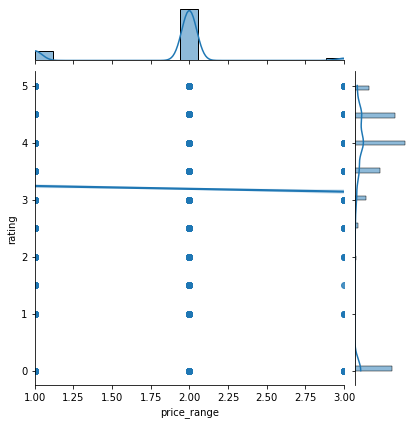

In [58]:
sns.jointplot(x='price_range', y='rating', data=data2, kind='reg')

Резюме - Price Range: в переменной очень много пропусков 13886 (34.7%). Чтобы не потерять информацию о пропусках создан новый критерий - 'empty_price'. Также создан новый признак числового кодирования цены - 'price_range' (низкая цена - 1, средняя цена -2 , высокая цена - 3). Пропуски заполнили медианой по городам.

## City

<AxesSubplot:>

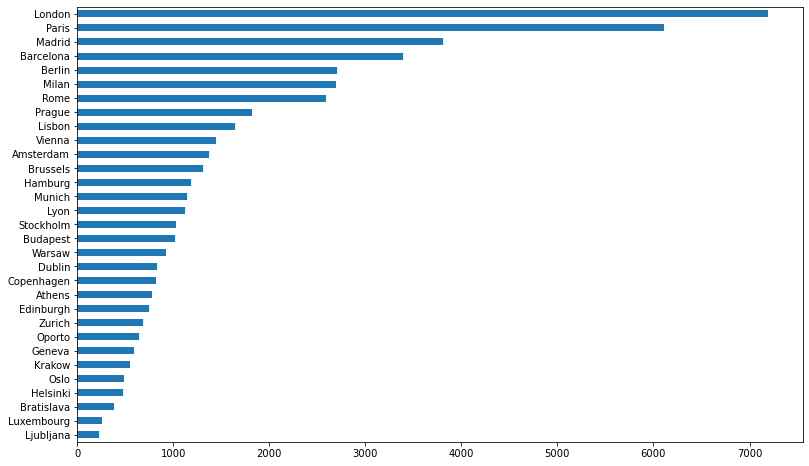

In [59]:
data2['city'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

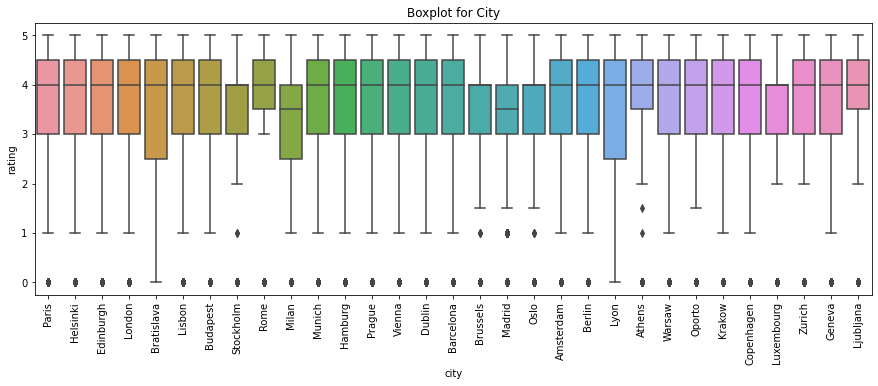

In [60]:
# Проверим распределение rating по городам.
fig, ax = plt.subplots(figsize = (15, 5))

sns.boxplot(x='city', y='rating',data=data2.loc[data2.loc[:, 'city'].isin(data2.loc[:, 'city'].value_counts().index[:])],ax=ax)

plt.xticks(rotation=90)
ax.set_title('Boxplot for City')

plt.show()

В Мадриде и Милане средние оценки ниже остальных городов. В Барселоне, Милане и Лионе более часто выставляют низкие оценки - смещение квартилей к нижней границе. В Брюсселе и Лионе больше всего нулевых оценок - нижний квартиль ограничивается именно этим значением.

In [61]:
show_city_dict(data2)

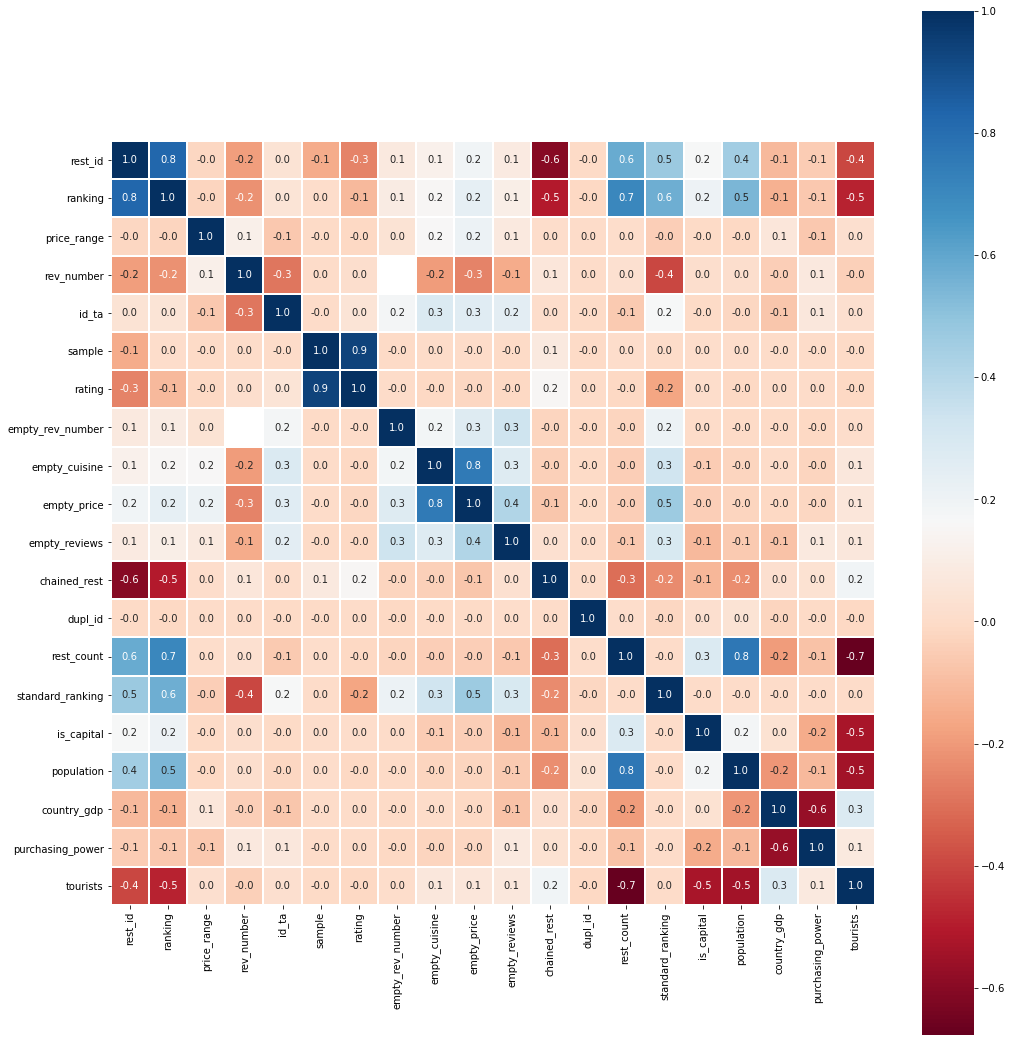

In [62]:
# Посмотрим на корреляционную матрицу.

plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(data2.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

Отмечаем сильные зависимости:
* rest_id & ranking
* sample & rating (условие задачи)
* empty_cuisine & empty_price ("плохая" наполняемость информацией о некоторых ресторанах?)
* ranking, rest_count, population, tourists (всё о размерах города)

In [63]:
# Вычисляем к-во ресторанов на 1 чел для города в каждой строке
data2['rest_per_pop'] = data2['rest_count'] / (data2['population'])

In [64]:
city_list_shorter(data2)

# check
data2['new_city'].value_counts()

Other        18040
London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Name: new_city, dtype: int64

In [65]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rest_id           50000 non-null  float64
 1   city              50000 non-null  object 
 2   cuisine_style     50000 non-null  object 
 3   ranking           50000 non-null  float64
 4   price_range       50000 non-null  float64
 5   rev_number        46800 non-null  float64
 6   reviews           50000 non-null  object 
 7   url_ta            50000 non-null  object 
 8   id_ta             50000 non-null  float64
 9   sample            50000 non-null  int64  
 10  rating            50000 non-null  float64
 11  empty_rev_number  50000 non-null  uint8  
 12  empty_cuisine     50000 non-null  uint8  
 13  empty_price       50000 non-null  uint8  
 14  empty_reviews     50000 non-null  float64
 15  chained_rest      50000 non-null  float64
 16  dupl_id           50000 non-null  float6

Резюме - City: Без пропусков, категориальный признак. В разделе Feature Engineering создадим новые признаки города по типу dummies для выделенного здесь списка наиболее часто встречающихся городов и городов Other (признак new_city).
Добавлены новые критерии:

* is_capital - столица
* population - население города (тыс. чел.)
* standard_ranking - средневзвешенный по количеству ресторанов в городе ранк
* country - страна (понадобиться далее для выделения локальных кухонь)
* country_gdp - валовый внутренний продукт стран
* purchasing power - покупательная способность населения городов
* tourists - туристическая привлекательность городов
* rest_count - количество ресторанов в городе
* rest_per_pop - количество ресторанов на 1 жителя города

## Cuisine Style

In [66]:
cols = ['Cuisine Style']; data_cuisine = data[cols].copy()

# вспомогательная переменная для создания нового признака
list_for_number_of_cuisines = data_cuisine['Cuisine Style'].apply(clean_name)

data_cuisine['Cuisine Style'] = data_cuisine['Cuisine Style'].apply(clean_name)
data_cuisine = data_cuisine.explode('Cuisine Style')

# Сколько типов кухонь представлено в наборе данных?
print('Сколько типов кухонь представлено в наборе данных?', data_cuisine['Cuisine Style'].nunique() - 1)

# Какая кухня представлена в наибольшем количестве ресторанов? Введите название кухни без кавычек или апострофов.
print('Какая кухня представлена в наибольшем количестве ресторанов?', '\n', data_cuisine['Cuisine Style'].value_counts()[:1])

# Какое среднее количество кухонь предлагается в одном ресторане?
# Если в данных отсутствует информация о типах кухонь, то считайте,
# что в этом ресторане предлагается только один тип кухни.
# Ответ округлите до одного знака после запятой.
print('Какое среднее количество кухонь предлагается в одном ресторане?', len(data_cuisine) / len(data))

Сколько типов кухонь представлено в наборе данных? 125
Какая кухня представлена в наибольшем количестве ресторанов? 
 'Vegetarian Friendly'    14021
Name: Cuisine Style, dtype: int64
Какое среднее количество кухонь предлагается в одном ресторане? 2.62532


In [67]:
# посмотрим что входит в столбец
data2['cuisine_style'].value_counts()

['Other']                                                                                      11590
['Italian']                                                                                     1332
['French']                                                                                      1019
['Spanish']                                                                                      860
['French', 'European']                                                                           503
                                                                                               ...  
['Mediterranean', 'German', 'European', 'Vegetarian Friendly']                                     1
['European', 'Spanish', 'Fusion', 'Gluten Free Options']                                           1
['Italian', 'European', 'Gluten Free Options', 'Vegetarian Friendly']                              1
['Healthy', 'Asian', 'Thai', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']

In [68]:
# переформатируем строку в список
data2['cuisine_style'] = data2['cuisine_style'].apply(lambda x: eval(x))

# Добавим признак кол-ва кухонь в ресторане.
# признак, характеризующий широту ассортимента конкретного ресторана
data2['cuisine_style_number'] = data2['cuisine_style'].apply(lambda x: len(x))

In [69]:
data2['cuisine_style_number']

0        2
1        5
2        1
3        5
4        6
        ..
49995    4
49996    5
49997    2
49998    5
49999    1
Name: cuisine_style_number, Length: 50000, dtype: int64

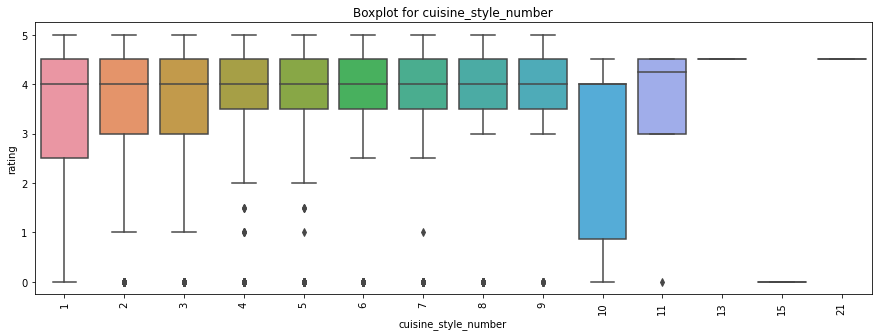

In [70]:
# Проверим распределение rating по признаку наличия дубликатов в ID_TA.
column = 'cuisine_style_number'
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x=column, y='rating',data=data2.loc[data2.loc[:, column].isin(data2.loc[:, column].value_counts().index[:])],ax=ax)
plt.xticks(rotation=90)
ax.set_title(f'Boxplot for {column}')
plt.show()

Посмтрим, какие кухни у нас чаще всего встречаются, а какие наоборот являются самыми редкими.


In [71]:
group_city_cuisine = data2.groupby(['city'])['cuisine_style'].sum().reset_index()
group_city_cuisine

,city,cuisine_style
0,Amsterdam,"[Dutch, European, Vegetarian Friendly, Vegan O..."
1,Athens,"[Greek, Other, Mediterranean, European, Greek,..."
2,Barcelona,"[Other, Mediterranean, Spanish, Vegetarian Fri..."
3,Berlin,"[Other, Cafe, German, Other, Italian, Pizza, O..."
4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve..."
5,Brussels,"[Italian, Mediterranean, Pizza, Moroccan, Medi..."
6,Budapest,"[Other, Italian, Pizza, Street Food, Hungarian..."
7,Copenhagen,"[European, Scandinavian, Danish, Italian, Pizz..."
8,Dublin,"[Italian, Pizza, European, Gluten Free Options..."
9,Edinburgh,"[Vegetarian Friendly, Seafood, European, Briti..."


Посчитаем кол-во уникальных кухонь, используя счетчик. Посмотрим, какие кухни входят топ-10, как самые часто встречающиеся и как самые редко встречающиеся.

In [72]:
c = Counter()

for cuisine_style in group_city_cuisine['cuisine_style']:
    for x in cuisine_style:
        c[x] += 1

print(c.most_common(10))
print()
print(c.most_common()[-10:])

[('Vegetarian Friendly', 14021), ('European', 12561), ('Other', 11590), ('Mediterranean', 7820), ('Italian', 7433), ('Vegan Options', 5684), ('Gluten Free Options', 5185), ('Bar', 4094), ('French', 3970), ('Asian', 3786)]

[('Caucasian', 4), ('Azerbaijani', 3), ('Welsh', 3), ('Yunnan', 2), ('Polynesian', 2), ('Fujian', 2), ('Latvian', 1), ('Burmese', 1), ('Salvadoran', 1), ('Xinjiang', 1)]


Посчитаем кол-во уникальных кухонь, используя счетчик. Посмотрим, какие кухни входят топ-10, как самые часто встречающиеся и как самые редко встречающиеся.

Добавим признак, имеет ли ресторан кухню, входящую в топ-10 по популярности и по редкости.

In [73]:
# сначала признак самых часто встречающихся кухонь

most_common_cuisines(data2)

<ipython-input-6-893bd347010c>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['most_common_cuisine'][i] = 1


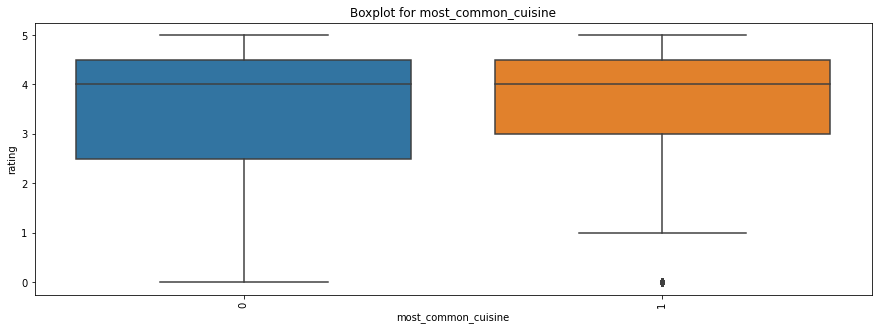

In [74]:
# Проверим распределение rating по признаку наличия дубликатов в ID_TA.
column = 'most_common_cuisine'
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x=column, y='rating',data=data2.loc[data2.loc[:, column].isin(data2.loc[:, column].value_counts().index[:])],ax=ax)
plt.xticks(rotation=90)
ax.set_title(f'Boxplot for {column}')
plt.show()

In [75]:
# теперь самые редкие

top_unique_cuisines(data2)

<ipython-input-6-893bd347010c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['top_unique_cuisine'][i] = 1


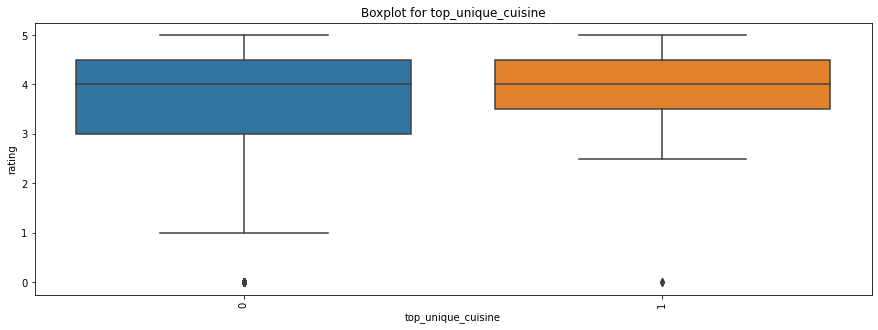

In [76]:
# Проверим распределение rating по признаку наличия дубликатов в ID_TA.
column = 'top_unique_cuisine'
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x=column, y='rating',data=data2.loc[data2.loc[:, column].isin(data2.loc[:, column].value_counts().index[:])],ax=ax)
plt.xticks(rotation=90)
ax.set_title(f'Boxplot for {column}')
plt.show()

Пока идем дальше, возможно, дальше еще какую-нибудь информацию сможем получить из признака кухонь.

In [77]:
data2[['rating', 'cuisine_style_number']].corr()

,rating,cuisine_style_number
rating,1.000000,0.034506
cuisine_style_number,0.034506,1.000000


In [78]:
# Флаги (1/0) isMostPopCusine - есть ли в ресторане самая популярная кухня;
# isMultyCusine - к-во кухонь в ресторане больше или столько же чем в среднем
average_cousines_count = np.round(len(data_cuisine) / len(data))
data2['isMostPopCusine'] = data2['cuisine_style'].apply(lambda x: 1 if 'Vegetarian Friendly' in x else 0)
data2['isMultyCusine'] = data2['cuisine_style_number'].apply(lambda x: 1 if  x >= average_cousines_count else 0)

# check
print(data2['isMostPopCusine'].value_counts())
print()
print(data2['isMultyCusine'].value_counts())

0    35979
1    14021
Name: isMostPopCusine, dtype: int64

0    28538
1    21462
Name: isMultyCusine, dtype: int64


In [79]:
show_veget(data2)

# check
data2['veget_cuisine'].value_counts()

<ipython-input-6-893bd347010c>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['veget_cuisine'][i] = 1


0    35018
1    14982
Name: veget_cuisine, dtype: int64

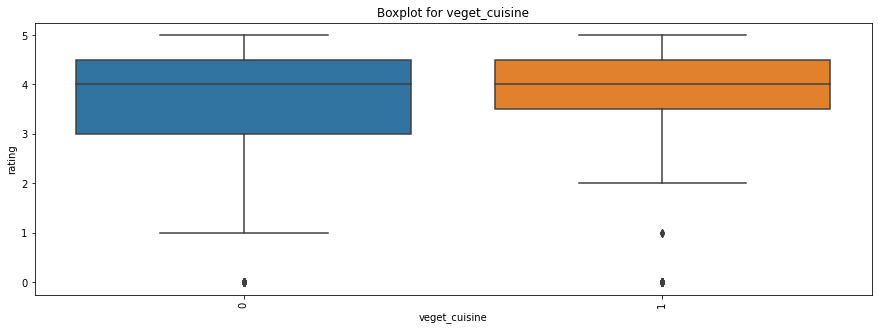

In [80]:
# Проверим распределение rating по признаку наличия дубликатов в ID_TA.
column = 'veget_cuisine'
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x=column, y='rating',data=data2.loc[data2.loc[:, column].isin(data2.loc[:, column].value_counts().index[:])],ax=ax)
plt.xticks(rotation=90)
ax.set_title(f'Boxplot for {column}')
plt.show()

In [81]:
show_junk_food(data2)

# check
data2['pop_cuisine'].value_counts()

<ipython-input-6-893bd347010c>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pop_cuisine'][i] = 1


0    30539
1    19461
Name: pop_cuisine, dtype: int64

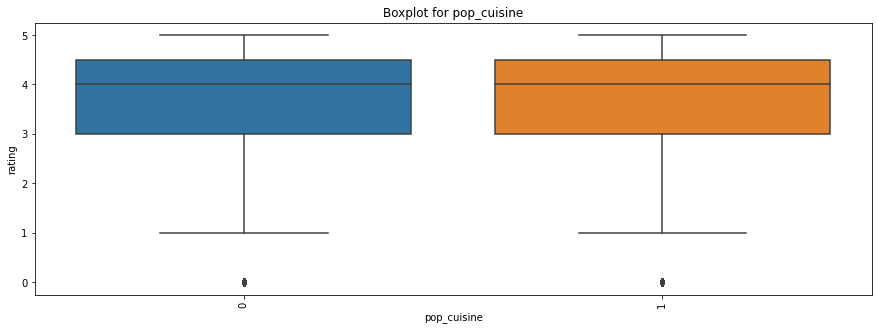

In [82]:
# Проверим распределение rating по признаку наличия дубликатов в ID_TA.
column = 'pop_cuisine'
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x=column, y='rating',data=data2.loc[data2.loc[:, column].isin(data2.loc[:, column].value_counts().index[:])],ax=ax)
plt.xticks(rotation=90)
ax.set_title(f'Boxplot for {column}')
plt.show()

In [83]:
show_local_food(data2)

# check
data2['local_cuisine'].value_counts()

<ipython-input-6-893bd347010c>:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['local_cuisine'][i] = 1


0    34096
1    15904
Name: local_cuisine, dtype: int64

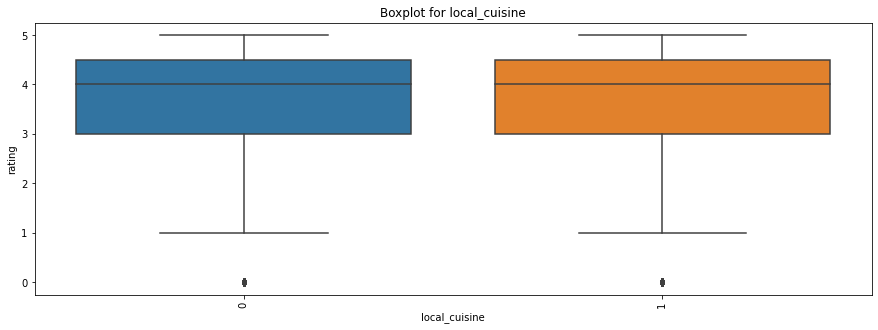

In [84]:
# Проверим распределение rating по признаку наличия дубликатов в ID_TA.
column = 'local_cuisine'
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x=column, y='rating',data=data2.loc[data2.loc[:, column].isin(data2.loc[:, column].value_counts().index[:])],ax=ax)
plt.xticks(rotation=90)
ax.set_title(f'Boxplot for {column}')
plt.show()

In [85]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rest_id               50000 non-null  float64
 1   city                  50000 non-null  object 
 2   cuisine_style         50000 non-null  object 
 3   ranking               50000 non-null  float64
 4   price_range           50000 non-null  float64
 5   rev_number            46800 non-null  float64
 6   reviews               50000 non-null  object 
 7   url_ta                50000 non-null  object 
 8   id_ta                 50000 non-null  float64
 9   sample                50000 non-null  int64  
 10  rating                50000 non-null  float64
 11  empty_rev_number      50000 non-null  uint8  
 12  empty_cuisine         50000 non-null  uint8  
 13  empty_price           50000 non-null  uint8  
 14  empty_reviews         50000 non-null  float64
 15  chained_rest       

Резюме - Cuisine Style: Много пропусков 9283 (23.2%). Чтобы сохранить эту информацию сформирован новый признак 'empty_cuisine'. Кроме этого, после обработки, добавлен критерий количества типов кухонь в ресторане 'cuisine_style_number', most_common_cuisine - рестораны с самыми часто встречающимися кухнями, top_unique_cuisine - рестораны с самыми редкими кухнями, isMostPopCuisine - рестораны с самым распространенным видом кухни - Vegetarian Friendly, isMultyCuisine - рестораны с ассортиментом кухонь больше среднего, veget_cuisine - рестораны вегетарианской кухни, pop_cuisine - рестораны с фаст-фудом, local_cuisine - рестораны с местной кухней. В новом признаке выбросов нет. В исходном критерии все типы кухонь были заполнены, [] пустых списков не было.

## Number of Reviews

Согласно TripAdvisor, количество отзывов влияет на ранг рестора. Визуализируем эти данные.

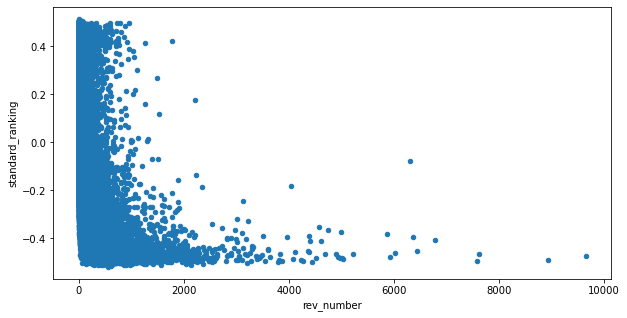

In [86]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
ax1 = data2.plot.scatter(x='rev_number', y='standard_ranking')
ax1.xaxis.get_label().set_visible(True)

In [87]:
data2['rev_number'].isna().sum()

3200

In [88]:
number_of_reviews(data2).head(5)

,rest_id,city,cuisine_style,ranking,price_range,rev_number,reviews,url_ta,id_ta,sample,rating,empty_rev_number,empty_cuisine,empty_price,empty_reviews,chained_rest,dupl_id,city_url,rest_count,standard_ranking,is_capital,country,population,country_gdp,purchasing_power,tourists,rest_per_pop,new_city,cuisine_style_number,most_common_cuisine,top_unique_cuisine,isMostPopCusine,isMultyCusine,veget_cuisine,pop_cuisine,local_cuisine
0,0.0,Paris,"[Bar, Pub]",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918.0,0,0.0,0,0,0,1.0,1.0,0.0,187147,6108,0.43,1,France,2187526,45454,22,1,0.002792,Paris,2,1,0,0,0,0,1,0
1,1.0,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944.0,0,0.0,0,0,0,0.0,1.0,0.0,189934,475,-0.40,1,Finland,631695,49334,9,5,0.000752,Other,5,1,0,1,1,1,0,1
2,2.0,Edinburgh,[Vegetarian Friendly],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638.0,0,0.0,0,0,0,0.0,1.0,0.0,186525,745,-0.04,1,United Kingdom,482005,44288,16,5,0.001546,Other,1,1,0,1,0,1,0,0
3,3.0,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417.0,0,0.0,0,0,0,0.0,1.0,0.0,186338,7193,-0.40,1,United Kingdom,8982000,44288,24,1,0.000801,London,5,1,0,1,1,1,1,0
4,4.0,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354.0,0,0.0,0,0,0,0.0,1.0,0.0,274924,380,-0.48,1,Slovakia,424428,32184,39,5,0.000895,Other,6,1,0,1,1,1,1,0


In [89]:
data2['rev_number'].isna().sum()

0

In [90]:
type(data2['rev_number'][0])

numpy.float64

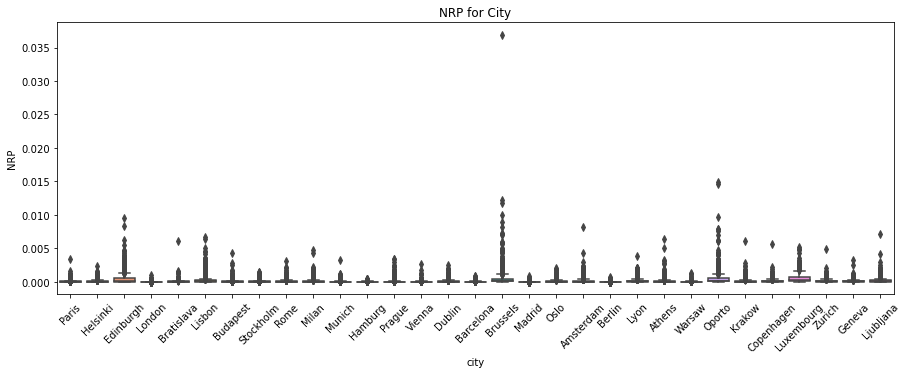

In [91]:
# Как часто в городе оставляют отзывы
data2['NRP'] = data2['rev_number'] / data2['population']

fig, ax = plt.subplots(figsize = (15, 5))

sns.boxplot(x='city', y='NRP',data=data2.loc[data2.loc[:, 'city'].isin(data2.loc[:, 'city'].value_counts().index[:])],ax=ax)

plt.xticks(rotation=45)
ax.set_title('NRP for City')

plt.show()

In [92]:
# посмотрим, есть ли выбросы

find_IQR(data2, 'rev_number')

Q1: 10.0
Q3: 105.0
IQR: 95.0
Граница выбросов: [-132.5,247.5]


In [93]:
# Посмотрим, сколько значений у нас выбиывается за верхнюю границу выбросов.

sum(data2['rev_number'] > 247.5)

6069

<AxesSubplot:>

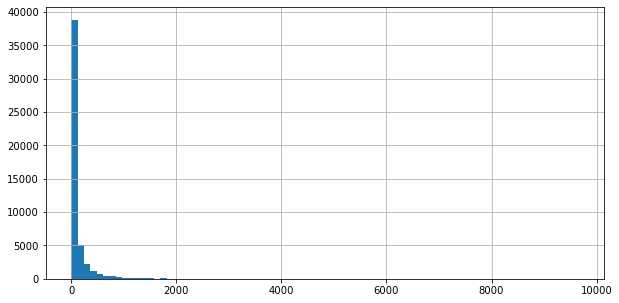

In [94]:
# Достаточно много. Посмотрим распределение на гистограмме, чтобы не отсекать сразу так много.

data2['rev_number'].hist(bins=80)

Q1: 10.0
Q3: 105.0
IQR: 95.0 
Граница выбросов: [-132.5, 247.5]


/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0

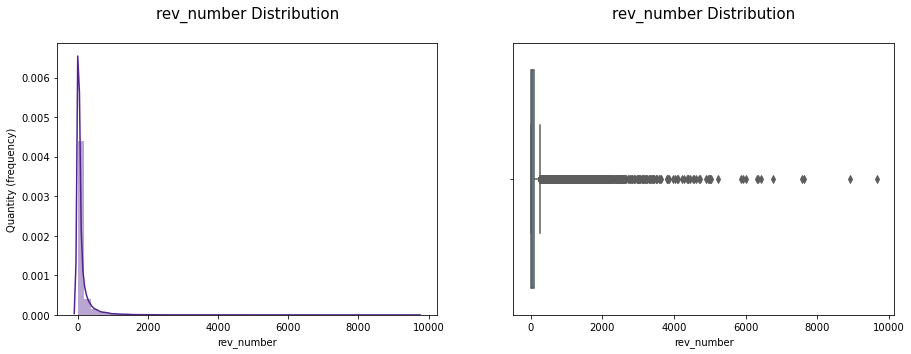

In [95]:
show_IQR(data2, "rev_number", 50)

Так, мы видим что гистограмма смещена вправо, хвост длинный и уходит на убыль где-то в районе значения 1200. Посмотрим, сколько у нас значения больше 1200.

In [96]:
sum(data2['rev_number'] > 1200)

571

In [97]:
fix_revs_outs(data2, 1200)

# проверим

print(data2['rev_number'].describe())
print()
print(data2['many_revs'].value_counts())

count    50000.000000
mean       109.615392
std        203.099935
min          2.000000
25%         10.000000
50%         33.000000
75%        105.000000
max       1200.000000
Name: rev_number, dtype: float64

0    49429
1      571
Name: many_revs, dtype: int64


In [98]:
edit_number_of_reviews(data2)

,rest_id,city,cuisine_style,ranking,price_range,rev_number,reviews,url_ta,id_ta,sample,rating,empty_rev_number,empty_cuisine,empty_price,empty_reviews,chained_rest,dupl_id,city_url,rest_count,standard_ranking,is_capital,country,population,country_gdp,purchasing_power,tourists,rest_per_pop,new_city,cuisine_style_number,most_common_cuisine,top_unique_cuisine,isMostPopCusine,isMultyCusine,veget_cuisine,pop_cuisine,local_cuisine,NRP,many_revs,mean_Number_of_Reviews_per_city,max_Number_of_Reviews_per_city,stand_Number_of_Reviews,reviews_per_each_person,reviews_per_city
0,0.0,Paris,"[Bar, Pub]",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918.0,0,0.0,0,0,0,1.0,1.0,0.0,187147,6108,0.43,1,France,2187526,45454,22,1,0.002792,Paris,2,1,0,0,0,0,1,0,0.000002,0,108.924844,1200.0,10.711729,-0.312389,108.924844
1,1.0,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944.0,0,0.0,0,0,0,0.0,1.0,0.0,189934,475,-0.40,1,Finland,631695,49334,9,5,0.000752,Other,5,1,0,1,1,1,0,1,0.000154,0,63.872545,1200.0,0.035106,0.217101,63.872545
2,2.0,Edinburgh,[Vegetarian Friendly],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638.0,0,0.0,0,0,0,0.0,1.0,0.0,186525,745,-0.04,1,United Kingdom,482005,44288,16,5,0.001546,Other,1,1,0,1,0,1,0,0,0.000058,0,204.281202,1200.0,0.504766,-0.116048,204.281202
3,3.0,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417.0,0,0.0,0,0,0,0.0,1.0,0.0,186338,7193,-0.40,1,United Kingdom,8982000,44288,24,1,0.000801,London,5,1,0,1,1,1,1,0,0.000022,0,119.043836,1200.0,1.291630,-0.240288,119.043836
4,4.0,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354.0,0,0.0,0,0,0,0.0,1.0,0.0,274924,380,-0.48,1,Slovakia,424428,32184,39,5,0.000895,Other,6,1,0,1,1,1,1,0,0.000382,0,46.610587,1200.0,-0.008009,1.013239,46.610587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,499.0,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,2.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,2104414.0,1,4.5,0,0,0,0.0,1.0,0.0,187849,2694,-0.42,0,Italy,1352000,40066,40,5,0.001993,Milan,4,1,0,1,1,1,0,1,0.000058,0,152.307548,1200.0,0.289744,-0.114857,152.307548
49996,6340.0,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,2.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,1800036.0,1,3.5,0,0,0,0.0,1.0,0.0,187147,6108,-0.04,1,France,2187526,45454,22,1,0.002792,Paris,5,1,0,1,1,1,0,1,0.000248,0,108.924844,1200.0,5.193396,0.545883,108.924844
49997,1649.0,Stockholm,"[Japanese, Sushi]",1652.0,2.0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,947615.0,1,4.5,0,0,1,0.0,1.0,0.0,189852,1033,0.17,1,Sweden,975551,52477,13,4,0.001059,Other,2,0,0,0,0,0,1,0,0.000004,0,71.564156,1200.0,1.317030,-0.304462,71.564156
49998,640.0,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,2.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,1100838.0,1,4.0,0,0,0,0.0,1.0,0.0,274856,925,-0.19,1,Poland,1708000,33739,29,3,0.000542,Other,5,1,0,1,1,1,0,1,0.000041,0,60.808664,1200.0,0.483493,-0.175747,60.808664


Резюме - Number of Reviews 2543 (6.4%) пропусков.

Провели нормализацию.

Выбросов много. Заменил. Сохранил информацию о них в отдельной переменной.

## Review Date

In [99]:
review_dt_extract(data2)

# граничные данные
print("Самая свежая дата", data2[['review_date_1', 'review_date_2']].max().max())
print("Самая раняя дата", data2[['review_date_1', 'review_date_2']].min().min())

max_days = abs(data2['review_date_1'] - data2['review_date_2']).max()
print("Количество дней", max_days)

Самая свежая дата 2018-02-26 00:00:00
Самая раняя дата 2004-04-21 00:00:00
Количество дней 3296 days 00:00:00


In [100]:
data2[['review_date_1', 'review_date_2']]

,review_date_1,review_date_2
0,NaT,NaT
1,2017-12-05,2017-10-29
2,2017-12-28,2017-12-06
3,2017-12-06,2017-11-22
4,2018-02-08,2018-01-24
...,...,...
49995,2017-12-16,2017-11-12
49996,2017-12-21,2017-12-12
49997,2016-11-03,2008-04-12
49998,2017-07-11,2017-06-18


## Самый акутальный отзыв, самые частые отзывы

In [101]:
data2['reviews'][100]

"[['Poor service, ugly menu and greasy food'], ['12/09/2015']]"

In [102]:
# преобразуем столбцы с датами в числовые значения
# для модели возьмем столбцы с самым свежим отзывов и с "частотой отзывов" - разностью дат между отзывами

data2['days_from_last_rev'] = abs(pd.to_datetime(data2['review_date_1']).sub(pd.Timestamp('2021-03-01')).dt.days)
data2['review_freq'] = abs((data2['review_date_1'] - data2['review_date_2']).dt.days)

Q1: 1181.0
Q3: 1454.0
IQR: 273.0 
Граница выбросов: [771.5, 1863.5]


/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count    41886.000000
mean      1396.746264
std        361.495337
min       1099.000000
25%       1181.000000
50%       1267.000000
75%       1454.000000
max       6158.000000
Name: days_from_last_rev, dtype: float64

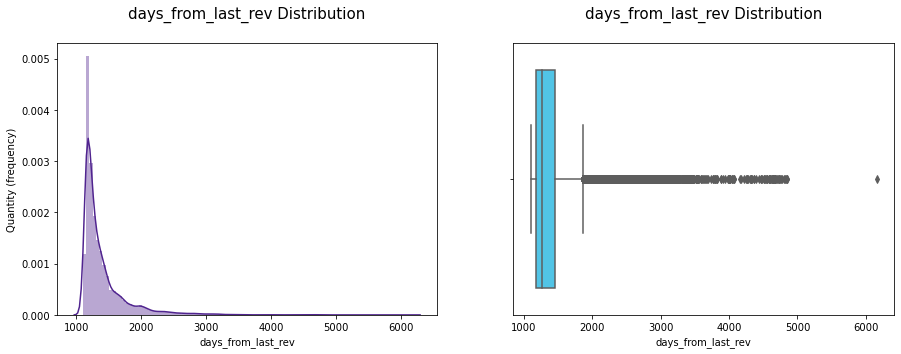

In [103]:
# построить график распределения отзывов по датам

show_IQR(data2, 'days_from_last_rev', 100)
data2['days_from_last_rev'].describe()

In [104]:
# определим границы выбросов
find_IQR(data2, 'days_from_last_rev')

Q1: 1181.0
Q3: 1454.0
IQR: 273.0
Граница выбросов: [771.5,1863.5]


In [105]:
# Посмотрим, сколько значений у нас выбиывается за верхнюю границу выбросов.

sum(data2['days_from_last_rev'] > 2500)

916

In [106]:
fix_last_rev_outs(data2, 2500)

# проверим

print(data2['days_from_last_rev'].describe())
print()
print(data2['no_recent_revs'].value_counts())

count    50000.000000
mean      1372.456750
std        283.308754
min       1099.000000
25%       1196.000000
50%       1289.000000
75%       1404.000000
max       2500.000000
Name: days_from_last_rev, dtype: float64

0    49084
1      916
Name: no_recent_revs, dtype: int64


Q1: 20.0
Q3: 173.0
IQR: 153.0 
Граница выбросов: [-209.5, 402.5]


/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/user/opt/mambaforge/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


count    36206.000000
mean       142.548832
std        222.554361
min          0.000000
25%         20.000000
50%         67.000000
75%        173.000000
max       3296.000000
Name: review_freq, dtype: float64

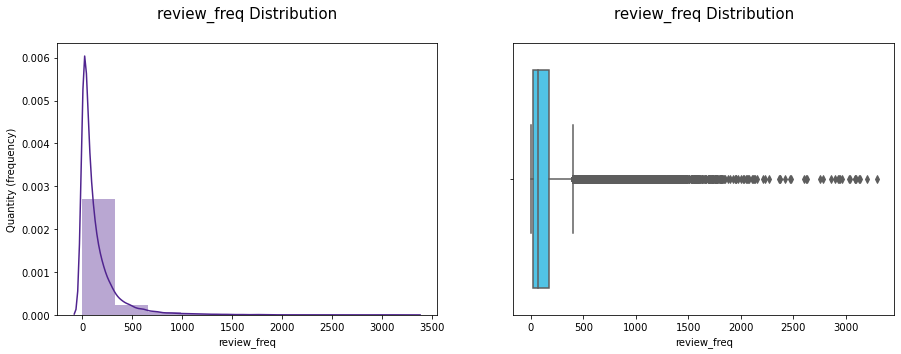

In [107]:
# построим график распределения разностей между двумя отзывами
# и определим границы выбросов

show_IQR(data2, 'review_freq')
data2['review_freq'].describe()

In [108]:
# Посмотрим, сколько значений у нас выбиывается за верхнюю границу выбросов.
sum(data2['review_freq'] > 600)

1446

In [109]:
fix_rev_freq_outs(data2, 600)

# проверим

print(data2['review_freq'].describe())
print()
print(data2['very_seldom_revs'].value_counts())

count    50000.000000
mean       115.965560
std        132.680269
min          0.000000
25%         34.000000
50%         82.000000
75%        122.000000
max        600.000000
Name: review_freq, dtype: float64

0    48554
1     1446
Name: very_seldom_revs, dtype: int64


In [110]:
display(data2['days_from_last_rev'].isna().sum())
display(data2['review_freq'].isna().sum())

0

0

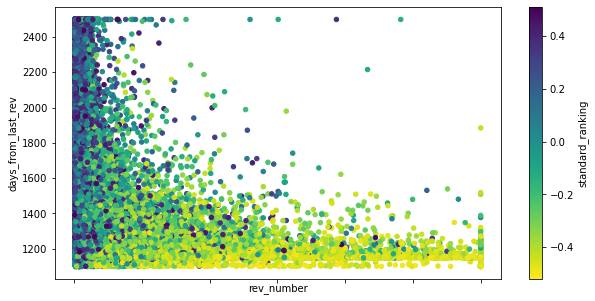

In [111]:
# Проверим зависимость времени последнего отзыва, от ранга и количества отзывов. Видно, что актуальность отзыва
# имеет большое значение на ранг ресторана.
plt.rcParams['figure.figsize'] = (10.0, 5.0)
ax1 = data2.plot.scatter(y='days_from_last_rev', x='rev_number', c='standard_ranking', colormap='viridis_r')
ax1.xaxis.get_label().set_visible(True)

## Месяц и год написания отзыва

In [112]:
show_month_year(data2)

display(data2['rev_m1'].isna().sum())
display(data2['rev_m2'].isna().sum())
display(data2['rev_y1'].isna().sum())
display(data2['rev_y2'].isna().sum())

0

0

0

0

<AxesSubplot:>

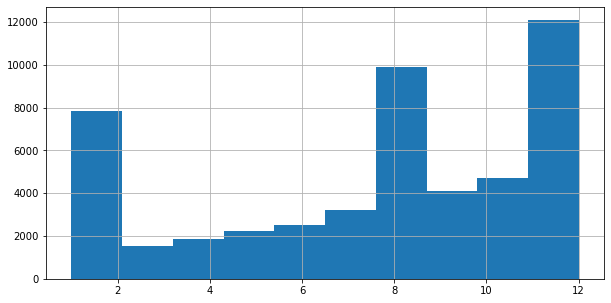

In [113]:
data2['rev_m1'].hist()

<AxesSubplot:>

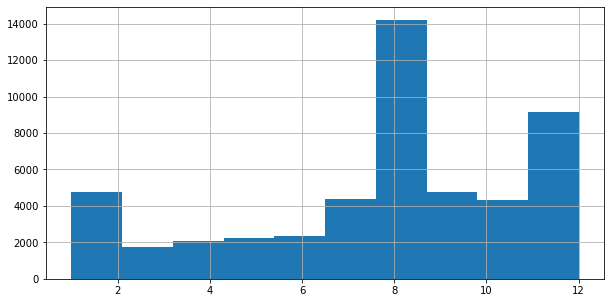

In [114]:
data2['rev_m2'].hist()

<AxesSubplot:>

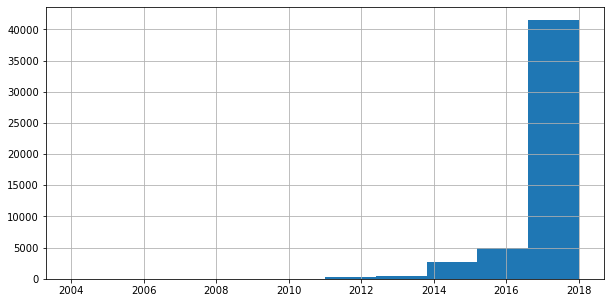

In [115]:
data2['rev_y1'].hist()

<AxesSubplot:>

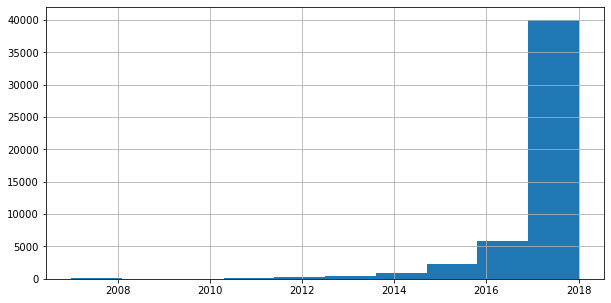

In [116]:
data2['rev_y2'].hist()

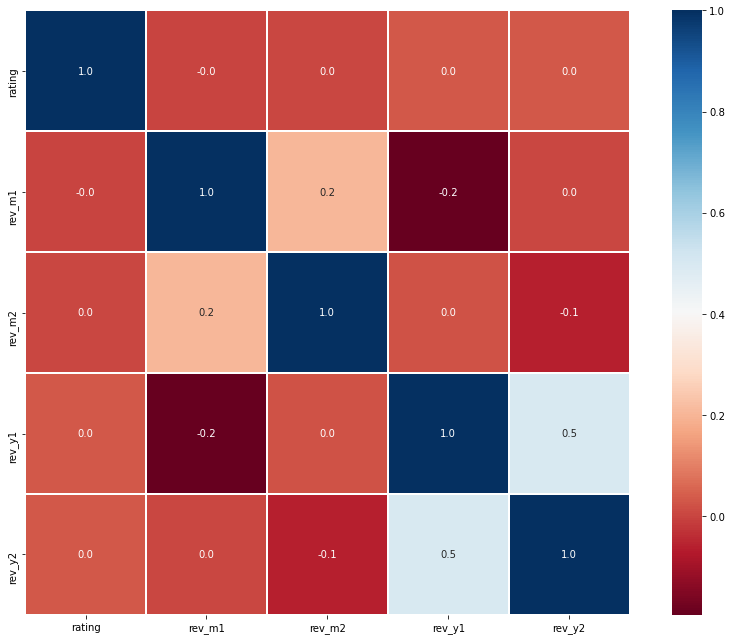

In [117]:
month_year_corr = data2[['rating', 'rev_m1', 'rev_m2', 'rev_y1', 'rev_y2']].corr()

plt.rcParams['figure.figsize'] = (12,9)
sns.heatmap(month_year_corr, square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

In [118]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   rest_id                          50000 non-null  float64       
 1   city                             50000 non-null  object        
 2   cuisine_style                    50000 non-null  object        
 3   ranking                          50000 non-null  float64       
 4   price_range                      50000 non-null  float64       
 5   rev_number                       50000 non-null  float64       
 6   reviews                          50000 non-null  object        
 7   url_ta                           50000 non-null  object        
 8   id_ta                            50000 non-null  float64       
 9   sample                           50000 non-null  int64         
 10  rating                           50000 non-null  float64  

В этом разделе мы плотно поработали с датами отзывов. Подготовлены новые признаки для модели:
* NRP - ненормированное кол-во отзывов на одного человека
* many_revs - флаг для ресторанов с кол-вом отзывов, выходящим за рамки
* review_date - даты отзывов из текстовой строки
* review_date_1 - дата первого отзыва
* review_date_2 - дата второго отзыва
* days_from_last_rev - кол-во дней с даты последнего отзыва
* review_freq - кол-во дней между отзывами
* no_recent_revs - флаг для ресторанов, у которых давно нет отзывов
* very_seldom_revs - флаг для ресторанов у которых очень редко оставляют отзывы
* rev_m1 - месяц первого отзыва
* rev_m2 - месяц второго отзыва
* rev_y1 - год первого отзыва
* rev_y2 - год второго отзыва
* mean_Number_of_Reviews_per_city - среднее кол-во отзывов по городу
* max_Number_of_Reviews_per_city - наибольшее число отзывов в городе
* stand_Number_of_Reviews - пронормированное кол-во отзывов по ресторанам
* reviews_per_each_person - прономированное кол-во отзывов на одного человека
* reviews_per_city - пронормированное кол-во отзывов по городам

## Reviews

In [119]:
show_reviews_and_len(data2)

<AxesSubplot:ylabel='Frequency'>

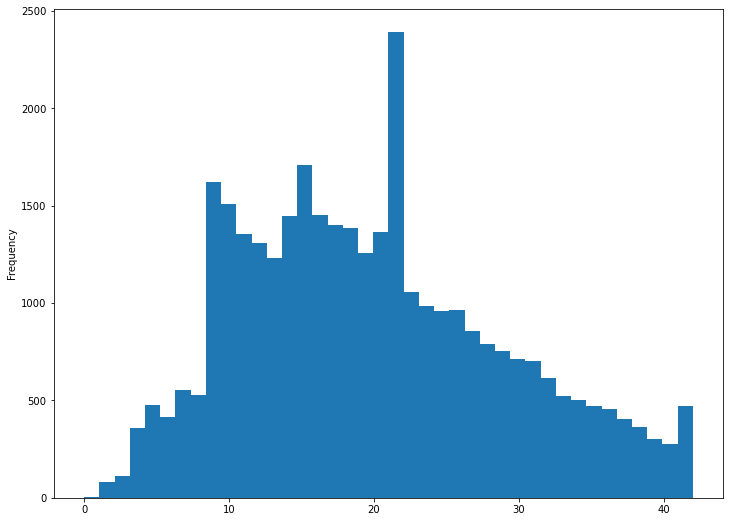

In [120]:
# Давайте посмотрим, в какой у нас диапазон длин комментариев
data2.review_1.str.len().plot(kind='hist', bins=40)

<AxesSubplot:ylabel='Frequency'>

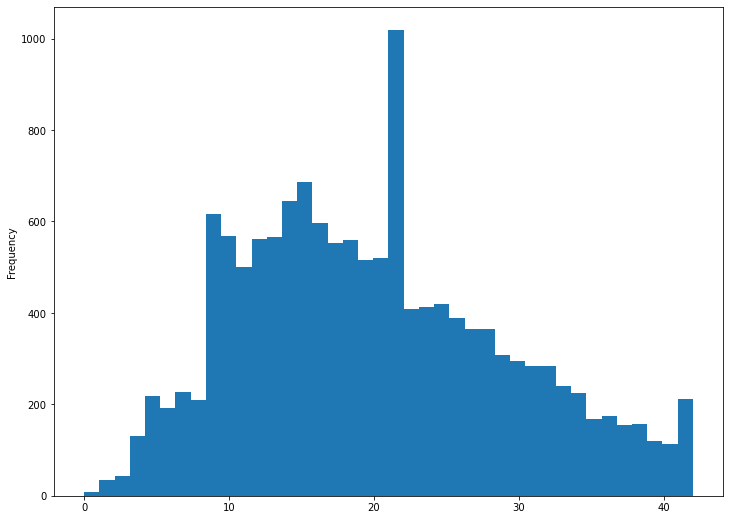

In [121]:
data2.review_2.str.len().plot(kind='hist', bins=40)

array([[<AxesSubplot:title={'center':'review_1_len'}>,
        <AxesSubplot:title={'center':'review_2_len'}>]], dtype=object)

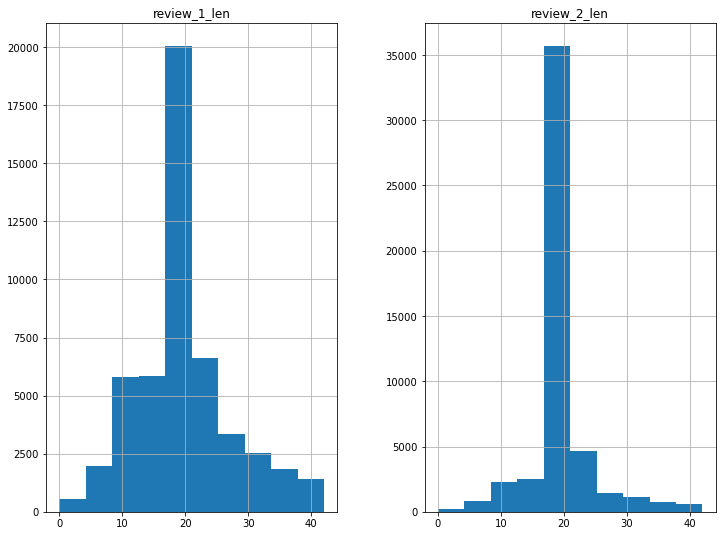

In [122]:
data2[['review_1_len', 'review_2_len']].hist()

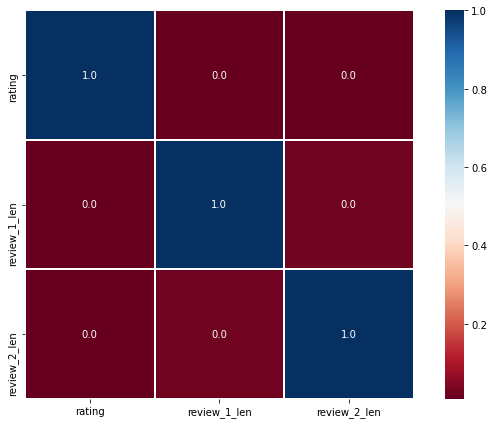

In [123]:
review_len_corr = data2[['rating', 'review_1_len', 'review_2_len']].corr()

plt.rcParams['figure.figsize'] = (9,6)
sns.heatmap(review_len_corr, square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

In [124]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 60 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   rest_id                          50000 non-null  float64       
 1   city                             50000 non-null  object        
 2   cuisine_style                    50000 non-null  object        
 3   ranking                          50000 non-null  float64       
 4   price_range                      50000 non-null  float64       
 5   rev_number                       50000 non-null  float64       
 6   reviews                          50000 non-null  object        
 7   url_ta                           50000 non-null  object        
 8   id_ta                            50000 non-null  float64       
 9   sample                           50000 non-null  int64         
 10  rating                           50000 non-null  float64  

Резюме - Reviews: Пропусков в тренировочном датасете нет, в тестовом - 2. Но есть 6471 незаполненных строк с отзывами в тренировочном датасете это 16% от датасета. В 5680 (14%) строках есть только один отзыв, хотя в подавляющем большинстве отзывов два.
Созданы новые критерии:

* empty_rev1 - флаг для "пустых" первых отзывов
* empty_rev2 - флаг для "пустых" вторых отзывов
* review_1_len - длина текста первого отзыва
* review_2_len - длина текста второго отзыва

## Good and Bad comments 

In [125]:
# typical reviews text

for i in range(1000, 1031):
    print(data2['reviews'][i])

[["You can't miss it"], ['09/04/2016']]
[['Bad food', 'terrible , dirty'], ['11/11/2017', '01/02/2018']]
[['Best cevapcici', 'Festive night.'], ['12/31/2017', '12/29/2017']]
[['Hands down the best Palestinian restaurant...', 'Cafe is no more'], ['10/21/2016', '09/21/2016']]
[['Oh WoW! This was good.'], ['10/05/2017']]
[['Good choice', 'A small gem near the Vatican'], ['08/25/2017', '06/26/2017']]
[['First class Thai restaurant', 'STYLISH THAI'], ['01/20/2017', '01/07/2016']]
[['Good Danish food and drink', 'Perfect lunch spot'], ['05/23/2017', '09/28/2016']]
[['Great Food and Great service', 'excellent cafe bar in the Marais'], ['07/09/2016', '06/03/2016']]
[['Very good food, nice service'], ['05/05/2017']]
[['Lovely Experience', 'walk through and lunch'], ['05/22/2017', '11/04/2014']]
[['Try the Urugay Steak with Chimichurri', 'Fabulous food where the locals eat'], ['10/16/2016', '10/15/2016']]
[[], []]
[['Calore e accoglienza come a casa/ warm and...', 'Very simple family osteria, ba

In [126]:
def show_good_bad_comms(data):
    # добавить переменные по наличие слов в отзывах: well, good, excellent, poor, bad, worse, best, but, friendly, nice, ok, great
    # without 'not'
    # .lower()
    check_words = ['well', 'good', 'excellent', 'poor', 'bad', 'worse', 'best', 'but', 'friendly', 'nice', 'ok', 'great', 'lovely']

    for word in check_words:
        data[word] = 0
        for i in range(len(data)):
            if word in data['reviews'][i].lower() and 'not' not in data['reviews'][i].lower():
                data.loc[i, word] = 1
            else:
                pass

In [127]:
show_good_bad_comms(data2)

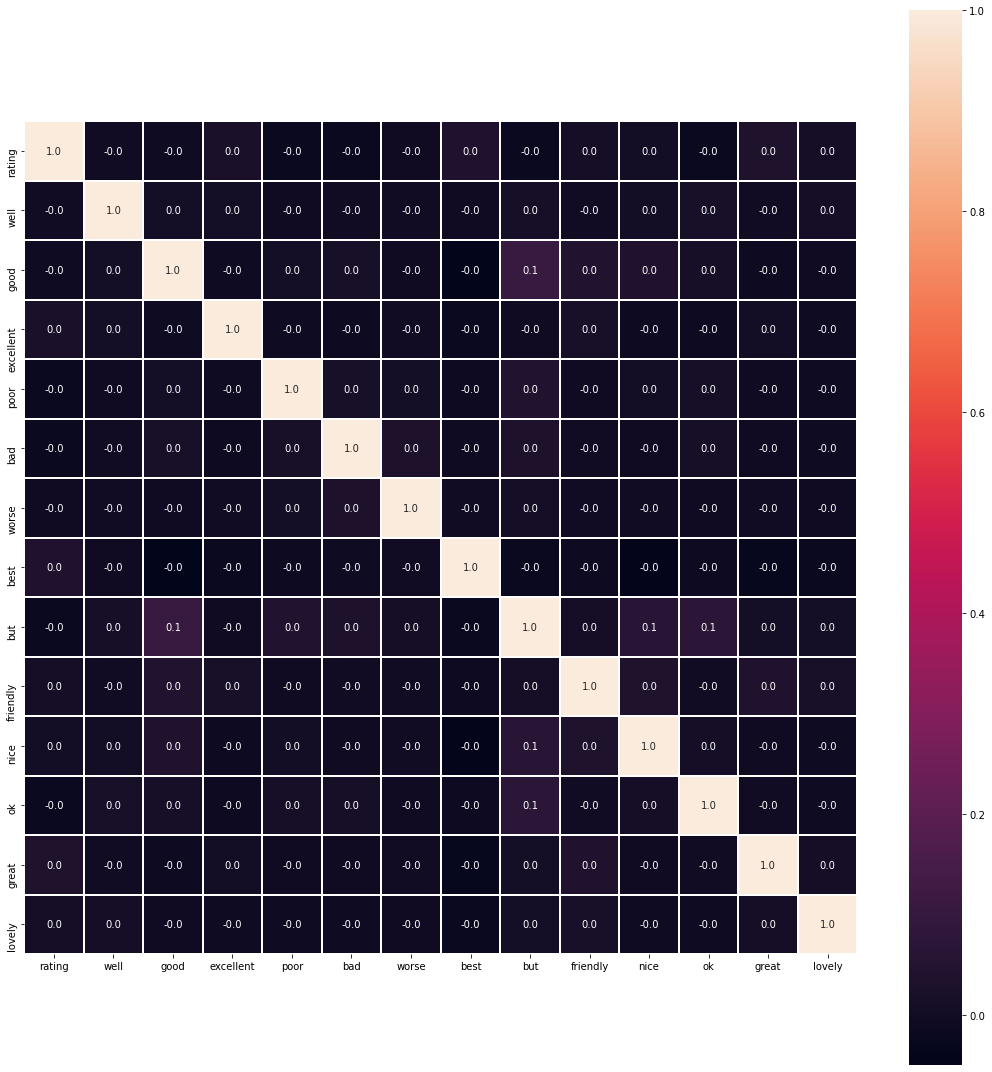

In [128]:
words_corr = data2[['rating', 'well', 'good', 'excellent', 'poor', 'bad', 'worse', 'best', 'but', 'friendly'
                              , 'nice', 'ok', 'great', 'lovely']].corr()

plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(words_corr, square=True,
            annot=True, fmt=".1f", linewidths=0.1);
plt.tight_layout()

## Нормированное на количество ресторанов в городе количество отзывов

In [129]:
# Добавим еще несколько переменных
def norm_reviews(input_df):
    df = input_df.copy()
    mean_rews_by_city = round((df.groupby(['city'])['rev_number'].sum() /
                               df.groupby(['city'])['ranking'].max()), 2)
    mean_rews = df.city.apply(lambda x: mean_rews_by_city[x])
    mean_rews.name = 'Mean_rews'
    df = pd.concat([df, mean_rews],axis=1)

    df['Rating_RevNr2'] = df.ranking * df['rev_number']+1
    df['Rating_RevNr'] = df.standard_ranking * df['rev_number']+1
    df['rel_numberOfRws'] = (df.standard_ranking)/(df.ranking)
    return df

In [130]:
data2 = norm_reviews(data2)

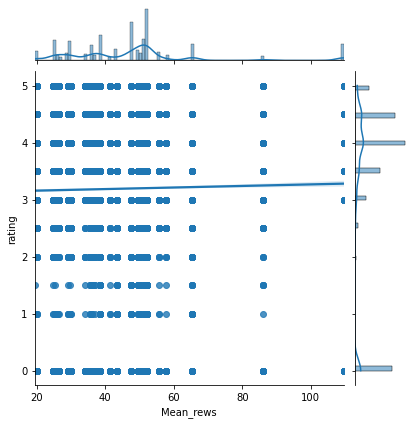

In [131]:
sns.jointplot(x='Mean_rews', y='rating', data=data2, kind='reg')

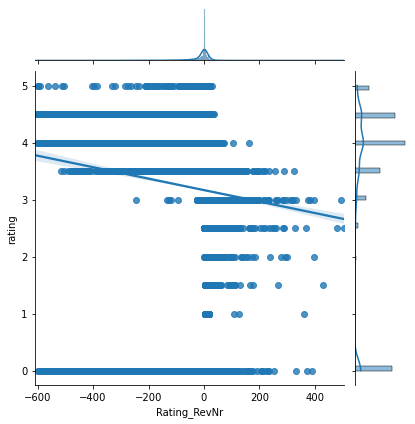

In [132]:
sns.jointplot(x='Rating_RevNr', y='rating', data=data2, kind='reg')

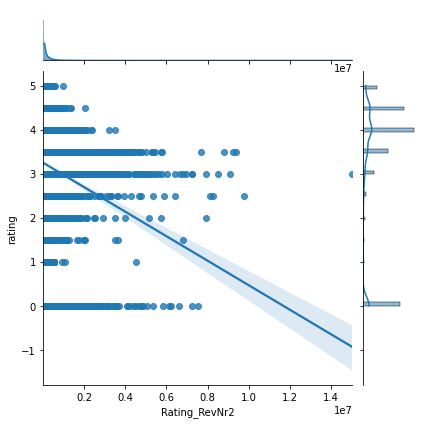

In [133]:
sns.jointplot(x='Rating_RevNr2', y='rating', data=data2, kind='reg')

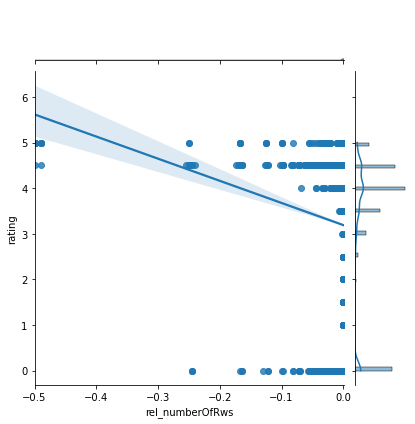

In [134]:
sns.jointplot(x='rel_numberOfRws', y='rating', data=data2, kind='reg')

В завершение Feature Engineering добавили флаги по присутствию в текстах отзывов положительно и отрицательно окрашенных слов, а также добавили еще несколько признаков, представляющих собой различные варианты нормирования количество отзывов и количества ресторанов по городам.

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение целевой переменной

<AxesSubplot:>

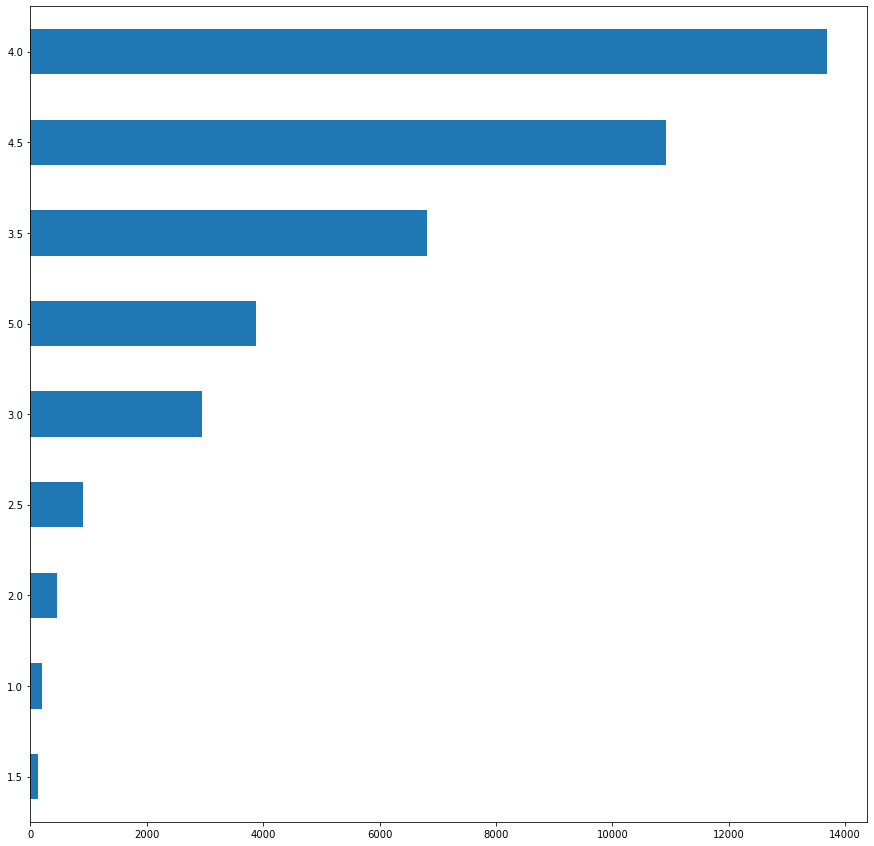

In [135]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

<AxesSubplot:>

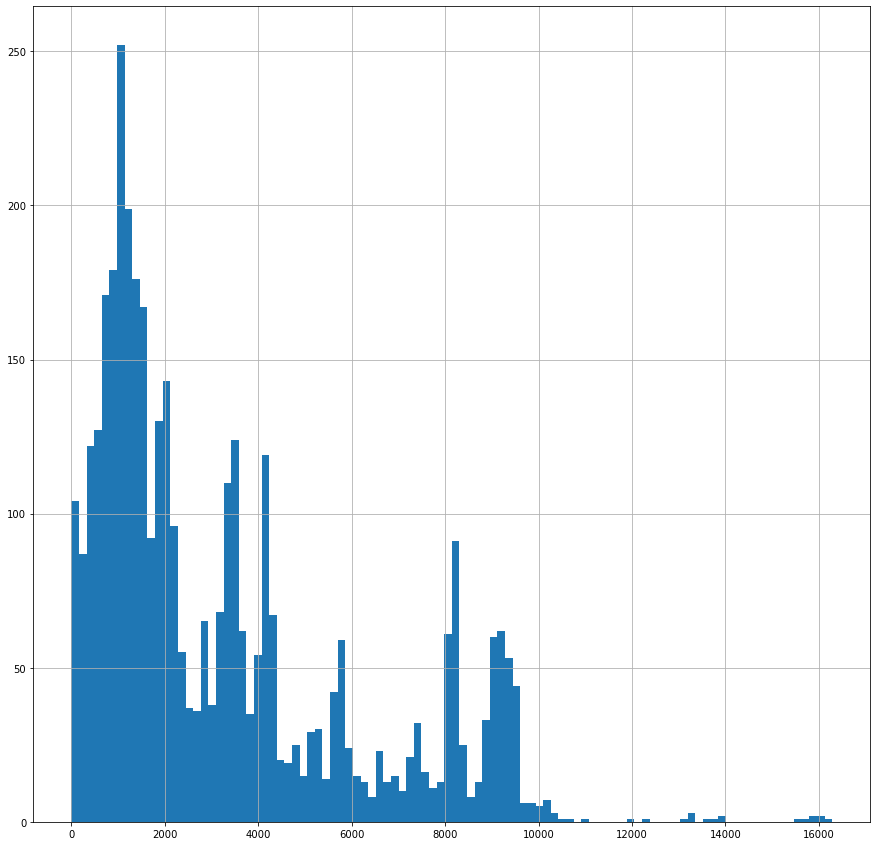

In [136]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

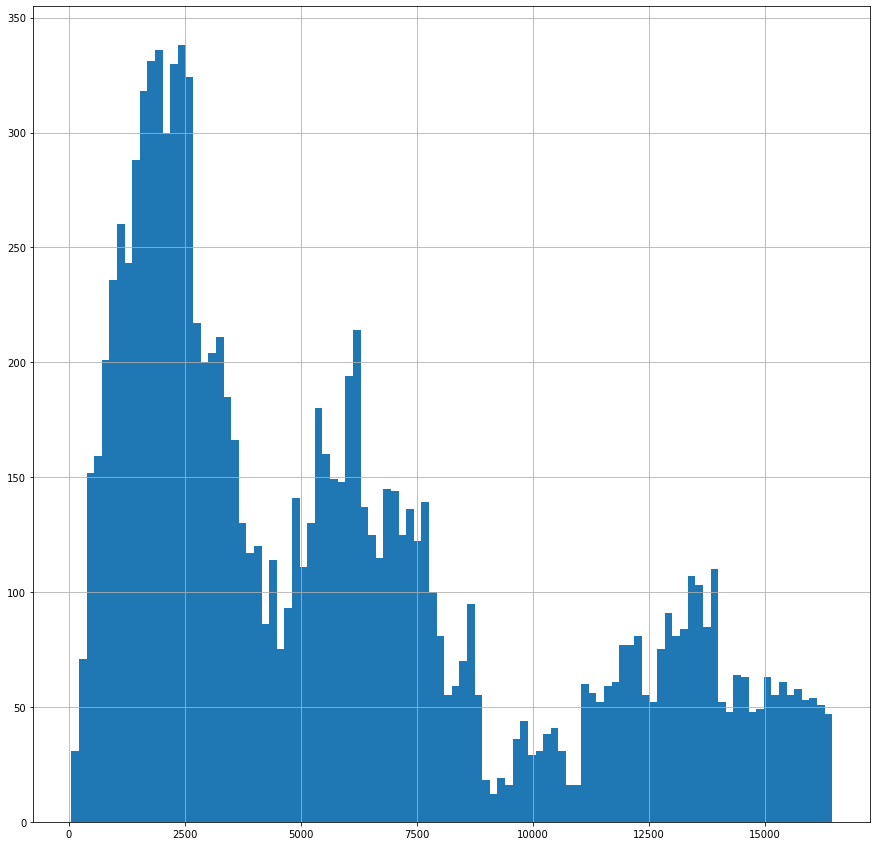

In [137]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

<AxesSubplot:>

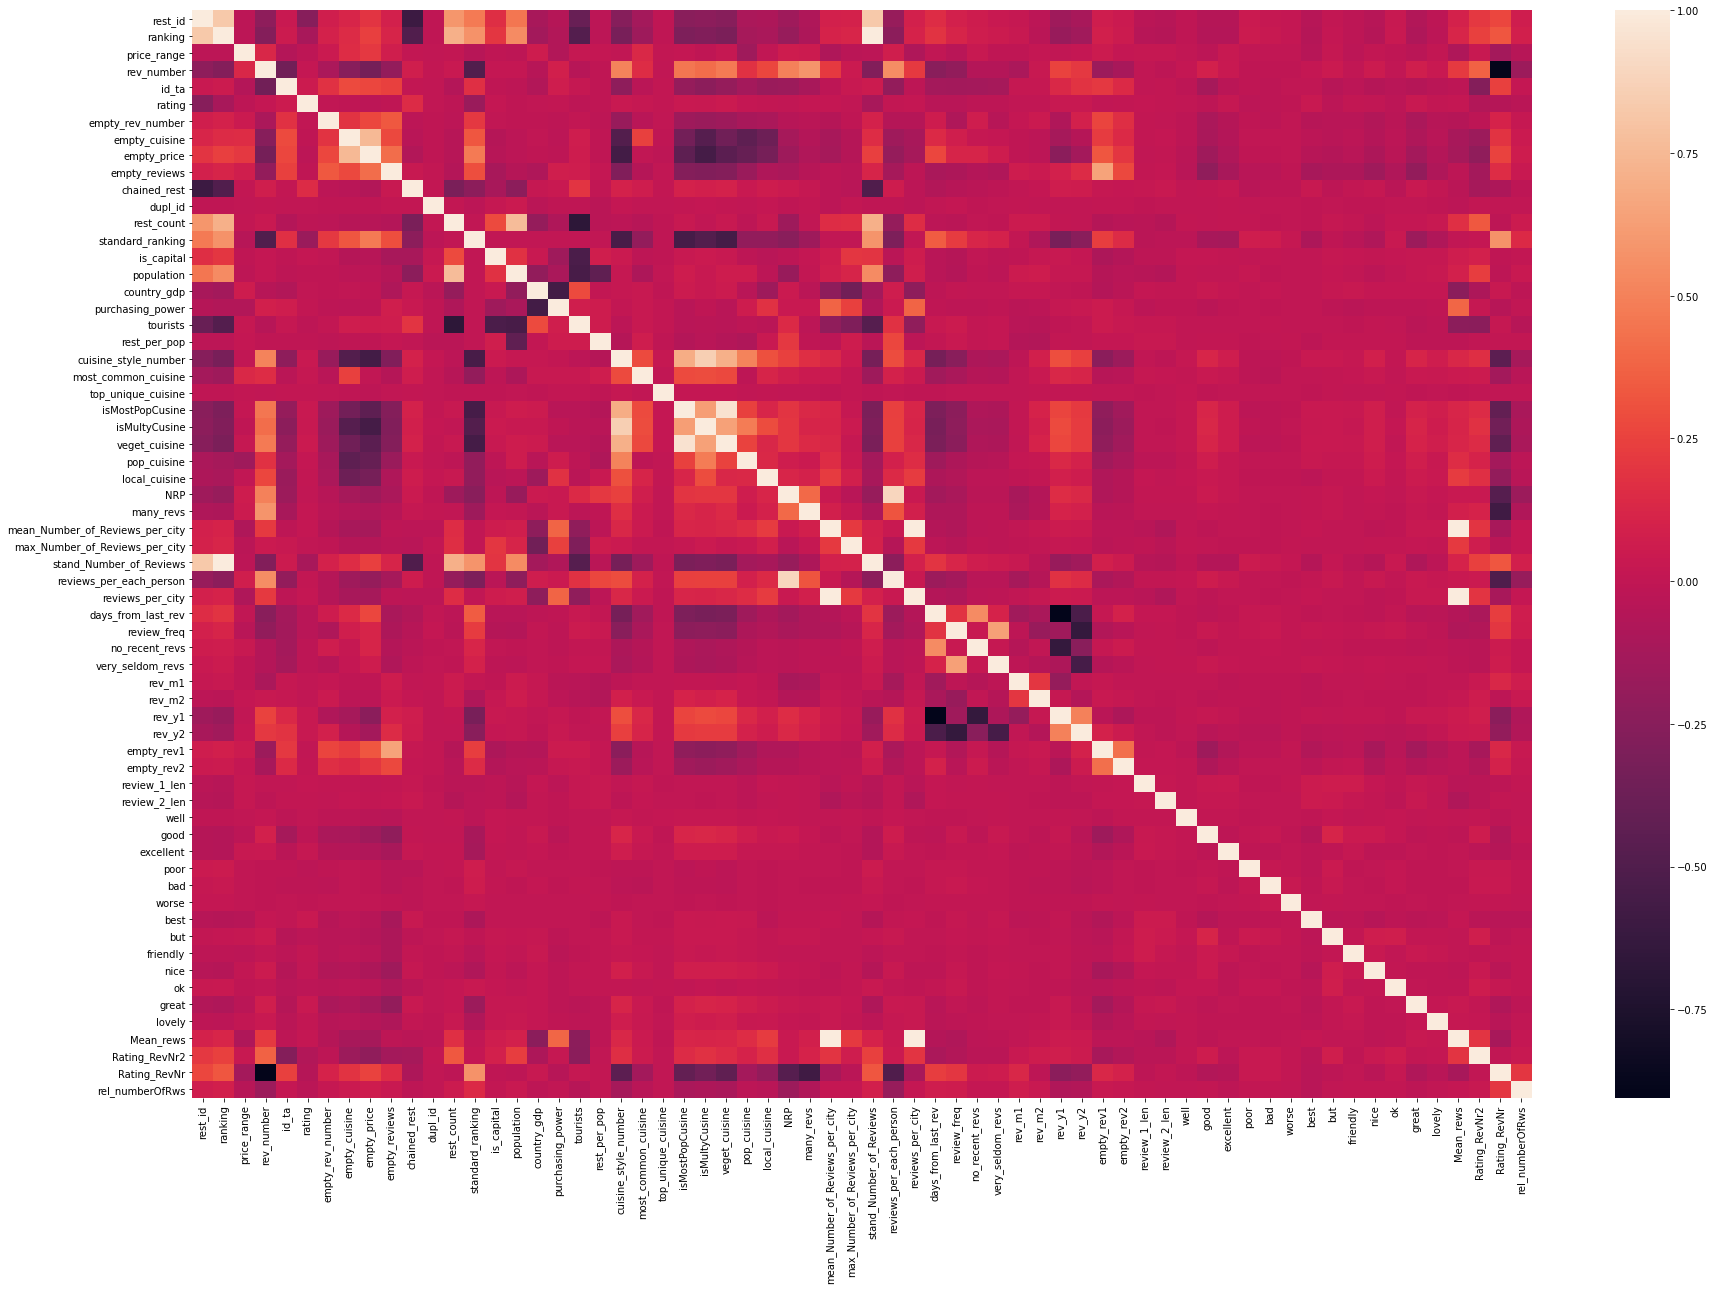

In [138]:
plt.rcParams['figure.figsize'] = (30,20)
sns.heatmap(data2.drop(['sample'], axis=1).corr())

# Стандартизируем числовые признаки

In [139]:
object_columns = [s for s in data2.columns if data2[s].dtypes == 'object']

# стандартизируем все столбцы кроме целевой и Sample
for i in list(data2.columns):
    if i not in ['rating','sample'] and i not in object_columns:
        data2[i] = StandardScaler_column(data2, i)
        if len(data2[data2[i].isna()]) < len(data2):
            data2[i] = data2[i].fillna(0)

In [140]:
data2.sample(5)

,rest_id,city,cuisine_style,ranking,price_range,rev_number,reviews,url_ta,id_ta,sample,rating,empty_rev_number,empty_cuisine,empty_price,empty_reviews,chained_rest,dupl_id,city_url,rest_count,standard_ranking,is_capital,country,population,country_gdp,purchasing_power,tourists,rest_per_pop,new_city,cuisine_style_number,most_common_cuisine,top_unique_cuisine,isMostPopCusine,isMultyCusine,veget_cuisine,pop_cuisine,local_cuisine,NRP,many_revs,mean_Number_of_Reviews_per_city,max_Number_of_Reviews_per_city,stand_Number_of_Reviews,reviews_per_each_person,reviews_per_city,review_date,review_date_1,review_date_2,days_from_last_rev,review_freq,no_recent_revs,very_seldom_revs,rev_m1,rev_m2,rev_y1,rev_y2,review_1,review_2,empty_rev1,empty_rev2,review_1_len,review_2_len,well,good,excellent,poor,bad,worse,best,but,friendly,nice,ok,great,lovely,Mean_rews,Rating_RevNr2,Rating_RevNr,rel_numberOfRws
15222,-0.957969,Prague,"[Italian, Seafood, Mediterranean, European, Ve...",-0.857130,0.286525,-0.071962,"[['Cozy Italian restaurant', 'An excelent even...",/Restaurant_Review-g274707-d8114410-Reviews-L_...,0.462619,1,4.5,-0.261488,-0.549313,-0.729321,-0.440132,0.28708,-0.038499,274707,-0.594649,-1.320357,0.562475,Chechia,-0.668825,-0.486950,0.387589,-0.946562,-0.069139,Prague,1.850143,0.448329,-0.020004,1.601899,1.153126,1.528836,1.252694,-0.68297,-0.066074,-0.10748,-0.217153,0.169609,-0.860781,-0.065503,-0.217153,"[11/20/2017, 09/25/2017]",0.444488,0.621077,-0.619319,-0.451960,-0.136609,-0.172573,0.995357,0.457094,0.209448,0.334876,Cozy Italian restaurant,An excelent evening meal with good winde,-0.682120,-1.598334,0.415770,4.099799,-0.082499,2.053673,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,-0.464994,-0.186347,-0.207683,-0.357067,-0.077988,0.010324
37048,0.353513,Madrid,[Pizza],0.418527,0.286525,-0.524946,"[[], []]",/Restaurant_Review-g187514-d5487124-Reviews-Do...,-0.204314,1,4.0,-0.261488,-0.549313,1.371138,2.272045,0.28708,-0.038499,187514,0.265473,0.312662,0.562475,Spain,1.137622,-0.681007,-0.206201,-0.277774,-0.695874,Madrid,-0.891069,-2.230503,-0.020004,-0.624259,-0.867208,-0.654093,1.252694,-0.68297,-0.252556,-0.10748,-0.475265,0.169609,0.421464,-0.317194,-0.475265,[],-2.271986,-1.620082,-0.137508,-0.127869,-0.136609,-0.172573,0.148038,0.124701,0.209448,0.334876,NaN,NaN,1.466018,0.625652,0.010084,0.043387,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,-0.464994,-0.186347,-0.467547,-0.431075,0.324551,0.083776
32049,-0.596881,Stockholm,[Turkish],-0.505513,-2.087731,-0.510175,"[['A nice place in the trendy Sodermalm'], ['1...",/Restaurant_Review-g189852-d3654800-Reviews-Li...,-0.669446,1,4.0,-0.261488,-0.549313,-0.729321,-0.440132,0.28708,-0.038499,189852,-0.931892,0.799093,0.562475,Sweden,-0.781774,0.612763,-0.948439,1.059801,-0.322247,Other,-0.891069,-2.230503,-0.020004,-0.624259,-0.867208,-0.654093,-0.798280,-0.68297,-0.237821,-0.10748,-0.867632,0.169609,-0.500463,-0.297307,-0.867632,[11/29/2012],0.404760,-1.620082,3.979949,-0.286146,7.320188,-0.172573,0.995357,0.124701,-5.204328,0.334876,A nice place in the trendy Sodermalm,NaN,-0.682120,0.625652,2.146776,-0.037215,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,2.955858,-0.171092,-0.464994,-0.186347,-0.908322,-0.442640,0.336837,0.094116
7198,0.906125,Lisbon,"[Italian, Pizza, Mediterranean, European, Vege...",-0.951453,0.286525,3.660228,"[['Wow ! Amazing restaurant', 'Excellent meal ...",/Restaurant_Review-g189158-d2295102-Reviews-It...,-1.014604,0,0.0,-0.261488,-0.549313,-0.729321,-0.440132,0.28708,-0.038499,189158,-0.667438,-1.598318,0.562475,Portugal,-0.941259,-1.133384,1.649394,0.391013,1.376537,Lisbon,2.398385,0.448329,-0.020004,1.601899,1.153126,1.528836,1.252694,-0.68297,4.116108,-0.10748,0.053840,0.169609,-0.958585,5.579117,0.053840,"[02/22/2018, 01/30/2018]",0.446543,0.623369,-0.951116,-0.700681,-0.136609,-0.172573,-1.546600,-2.2

## Get-dummies

In [141]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
city_dummies = pd.get_dummies(data2['new_city'], prefix='city')
data2 = data2.join(city_dummies)
data2.head(5)

# от введения dummy-переменные для каждого вида кухни откажемся
# кухонь слишком много, модель будет перегружена
# также введено достаточно признаков, характеризующих разные виды кухонь
# cuisine_dummies = pd.get_dummies(data2['cuisine_style'].explode(), prefix='cuisine').sum(level=0)
# data2 = data2.join(cuisine_dummies)

,rest_id,city,cuisine_style,ranking,price_range,rev_number,reviews,url_ta,id_ta,sample,rating,empty_rev_number,empty_cuisine,empty_price,empty_reviews,chained_rest,dupl_id,city_url,rest_count,standard_ranking,is_capital,country,population,country_gdp,purchasing_power,tourists,rest_per_pop,new_city,cuisine_style_number,most_common_cuisine,top_unique_cuisine,isMostPopCusine,isMultyCusine,veget_cuisine,pop_cuisine,local_cuisine,NRP,many_revs,mean_Number_of_Reviews_per_city,max_Number_of_Reviews_per_city,stand_Number_of_Reviews,reviews_per_each_person,reviews_per_city,review_date,review_date_1,review_date_2,days_from_last_rev,review_freq,no_recent_revs,very_seldom_revs,rev_m1,rev_m2,rev_y1,rev_y2,review_1,review_2,empty_rev1,empty_rev2,review_1_len,review_2_len,well,good,excellent,poor,bad,worse,best,but,friendly,nice,ok,great,lovely,Mean_rews,Rating_RevNr2,Rating_RevNr,rel_numberOfRws,city_Barcelona,city_Berlin,city_Lisbon,city_London,city_Madrid,city_Milan,city_Other,city_Paris,city_Prague,city_Rome
0,-1.094732,Paris,"[Bar, Pub]",2.513090,0.286525,-0.520022,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,1.130877,0,0.0,-0.261488,-0.549313,-0.729321,2.272045,0.28708,-0.038499,187147,1.253945,1.493995,0.562475,France,-0.371242,-0.021125,-0.280425,-0.946562,1.013545,Paris,-0.342827,0.448329,-0.020004,-0.624259,-0.867208,-0.654093,1.252694,-0.682970,-0.248996,-0.10748,-0.015746,0.169609,2.516346,-0.312389,-0.015746,[],-2.271986,-1.620082,-0.238106,-0.225850,-0.136609,-0.172573,0.148038,0.124701,0.209448,0.334876,NaN,NaN,1.466018,0.625652,0.035980,0.026777,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,-0.464994,-0.186347,0.010352,-0.345165,0.340600,0.085259,0,0,0,0,0,0,0,1,0,0
1,-1.094454,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",-0.961723,0.286525,-0.062115,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,0.097212,0,0.0,-0.261488,-0.549313,-0.729321,-0.440132,0.28708,-0.038499,189934,-1.172227,-1.389847,0.562475,Finland,-0.898248,0.329079,-1.245334,1.728588,-0.558796,Other,1.301900,0.448329,-0.020004,1.601899,1.153126,1.528836,-0.798280,1.464194,0.143312,-0.10748,-1.043013,0.169609,-0.955846,0.217101,-1.043013,"[12/05/2017, 10/29/2017]",0.444816,0.621690,-0.672265,-0.595163,-0.136609,-0.172573,1.277797,0.789487,0.209448,0.334876,Fine dining in Hakaniemi,NaN,-0.682120,0.625652,0.548924,0.217773,-0.082499,2.053673,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,-0.464994,-0.186347,-1.086619,-0.443784,-0.107872,-0.269555,0,0,0,0,0,0,1,0,0,0
2,-1.094176,Edinburgh,[Vegetarian Friendly],-0.771455,0.286525,-0.401852,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,1.735727,0,0.0,-0.261488,-0.549313,-0.729321,-0.440132,0.28708,-0.038499,186525,-1.055936,-0.139024,0.562475,United Kingdom,-0.948953,-0.126367,-0.725768,1.728588,0.052864,Other,-0.891069,0.448329,-0.020004,1.601899,-0.867208,1.528836,-0.798280,-0.682970,-0.103523,-0.10748,2.158538,0.169609,-0.803106,-0.116048,2.158538,"[12/28/2017, 12/06/2017]",0.445319,0.622376,-0.753450,-0.708218,-0.136609,-0.172573,1.277797,1.454274,0.209448,0.334876,Better than the Links,Ivy Black,-0.682120,-1.598334,0.149461,-2.265498,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,-0.464994,-0.186347,2.029135,-0.414371,0.309167,0.077564,0,0,0,0,0,0,1,0,0,0
3,-1.093898,London,"[Italian, Mediterranean, European, Vegetarian ...",-0.539297,2.660782,0.454877,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,-1.424489,0,0.0,-0.261488,-0.549313,-0.729321,-0.440132,0.28708,-0.038499,186338,1.721263,-1.389847,0.562475,United Kingdom,1.930250,-0.126367,-0.131977,-0.946562,-0.521127,London,1.301900,0.448329,-0.020004,1.601899,1.153126,1.528836,1.252694,-0.682970,-0.

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [142]:
# на всякий случай, заново подгружаем данные
DATA_DIR = './kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [143]:
def preproc_data2(df_input):
    '''includes several functions to pre-process the predictor data.'''
    df_output = df_input.copy()
    
    # ################### 0. Добавляем внешнюю классификацию кухонь ###################
    df_output["Country"] = df_output.City.map(country_dict)
    df_output["Cuisine Style deserialized"] = df_output["Cuisine Style"].fillna("[]").apply(lambda x: eval(x))
    df_output['cuisine_origin'] = df_output["Cuisine Style deserialized"].apply(cuisine_origin)
    df_output['cuisine_spec'] = df_output["Cuisine Style deserialized"].apply(cuisine_spec)
    df_output['is_local_cuisine'] = df_output.apply(is_local_cuisine, axis=1)
    
    # ################### 1. Предобработка ###################
    # Rename columns
    df_output.rename(columns={'Restaurant_id': 'rest_id', 'City': 'city', 'Cuisine Style': 'cuisine_style'
                              , 'Ranking': 'ranking', 'Rating': 'rating', 'Price Range': 'price_range'
                              , 'Number of Reviews': 'rev_number', 'Reviews': 'reviews', 'URL_TA': 'url_ta'
                              , 'ID_TA': 'id_ta'}, inplace=True)

    # Предобработка
    df_output['rest_id'] = df_output['rest_id'].apply(lambda x: float(x[3:]))
    df_output['id_ta'] = df_output['id_ta'].apply(lambda x: float(x[1:]))
    
    # ################### 2. NAN ###################
    df_output['empty_rev_number'] = pd.isna(df_output['rev_number']).astype('uint8')
    df_output['empty_cuisine'] = pd.isna(df_output['cuisine_style']).astype('uint8')
    df_output['cuisine_style'] = df_output['cuisine_style'].fillna("['Other']")
    df_output['empty_price'] = pd.isna(df_output['price_range']).astype('uint8')
    df_output['reviews'] = df_output['reviews'].fillna('[[], []]')
    df_output['empty_reviews'] = (df_output['reviews'] == '[[], []]').astype('float64')
    
    # ################### 3. Encoding & Feature Engineering ###################
    # Restaraunt_id
    show_chained_rest(df_output)
    
    # ID_TA
    show_duplicated_id(df_output)
    
    # Ranking
    ranking_normalize(df_output)

    # Price Range
    show_price_range(df_output)

    # City
    show_city_dict(df_output)
    df_output['rest_per_pop'] = df_output['rest_count'] / (df_output['population'])
    city_list_shorter(df_output)
    
    # Cuisine Style
    cols = ['Cuisine Style']; data_cuisine = df_input[cols].copy()
    # вспомогательная переменная для создания нового признака
    list_for_number_of_cuisines = data_cuisine['Cuisine Style'].apply(clean_name)
    data_cuisine['Cuisine Style'] = data_cuisine['Cuisine Style'].apply(clean_name)
    data_cuisine = data_cuisine.explode('Cuisine Style')
    
    df_output['cuisine_style'] = df_output['cuisine_style'].apply(lambda x: eval(x))
    df_output['cuisine_style_number'] = df_output['cuisine_style'].apply(lambda x: len(x))

    most_common_cuisines(df_output)
    top_unique_cuisines(df_output)
    
    average_cousines_count = np.round(len(data_cuisine) / len(df_output))
    df_output['isMostPopCusine'] = df_output['cuisine_style'].apply(lambda x: 1 if 'Vegetarian Friendly' in x else 0)
    df_output['isMultyCusine'] = df_output['cuisine_style_number'].apply(lambda x: 1 if  x >= average_cousines_count else 0)

    show_veget(df_output)
    show_junk_food(df_output)
    show_local_food(df_output)
    
    # Number of Reviews
    number_of_reviews(df_output)
    df_output['NRP'] = df_output['rev_number'] / df_output['population']
    fix_revs_outs(df_output, 1200)
    edit_number_of_reviews(df_output)

    # Review Date
    review_dt_extract(df_output)
    df_output['days_from_last_rev'] = abs(pd.to_datetime(df_output['review_date_1']).sub(pd.Timestamp('2021-03-01')).dt.days)
    df_output['review_freq'] = abs((df_output['review_date_1'] - df_output['review_date_2']).dt.days)

    fix_last_rev_outs(df_output, 2500)
    fix_rev_freq_outs(df_output, 600)

    show_month_year(df_output)
    
    # Reviews
    show_reviews_and_len(df_output)
    show_good_bad_comms(df_output)
    norm_reviews(df_output)
    
    # Get-dummies for City
    city_dummies = pd.get_dummies(df_output['new_city'], prefix='city')
    df_output = df_output.join(city_dummies)

    # Стандартизация признаков
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']

    # стандартизируем все столбцы кроме целевой и Sample
    for i in list(df_output.columns):
        if i not in ['rating','sample'] and i not in object_columns:
            df_output[i] = StandardScaler_column(df_output, i)
            if len(df_output[df_output[i].isna()]) < len(df_output):
                df_output[i] = df_output[i].fillna(0)
    
    # ################### 4. Clean ################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    time_values = ['review_date_1', 'review_date_2']
    bad_values = ['rest_id', 'rest_count', 'empty_cuisine']
    df_output.drop(object_columns, axis = 1, inplace=True)
    df_output.drop(time_values, axis = 1, inplace=True)
    df_output.drop(bad_values, axis = 1, inplace=True)

    return df_output

По хорошему, надо бы создать отдельный внешний модуль для всех подфункций, задействованных в этой функции. И словари сохранить вовне в виде json. Ноутбук перематывать туда-обратно - то ещё удовольствие, хочется перевести в текст, всё отрефакторить и сохранить в виде нормальных **.py** файлов, но я твёрдо решил использовать платформу Кеггла, может наконец проникнусь ноутбуками.

Запускаем и проверяем что получилось

In [144]:
data.columns.tolist()

['Restaurant_id',
 'City',
 'Cuisine Style',
 'Ranking',
 'Price Range',
 'Number of Reviews',
 'Reviews',
 'URL_TA',
 'ID_TA',
 'sample',
 'Rating']

In [145]:
df_preproc = preproc_data2(data)
df_preproc.sample(10)

<ipython-input-6-893bd347010c>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['most_common_cuisine'][i] = 1
<ipython-input-6-893bd347010c>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['top_unique_cuisine'][i] = 1
<ipython-input-6-893bd347010c>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['veget_cuisine'][i] = 1
<ipython-input-6-893bd347010c>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy

,ranking,price_range,rev_number,id_ta,sample,rating,is_local_cuisine,empty_rev_number,empty_price,empty_reviews,chained_rest,dupl_id,standard_ranking,is_capital,population,country_gdp,purchasing_power,tourists,rest_per_pop,cuisine_style_number,most_common_cuisine,top_unique_cuisine,isMostPopCusine,isMultyCusine,veget_cuisine,pop_cuisine,local_cuisine,NRP,many_revs,mean_Number_of_Reviews_per_city,max_Number_of_Reviews_per_city,stand_Number_of_Reviews,reviews_per_each_person,reviews_per_city,days_from_last_rev,review_freq,no_recent_revs,very_seldom_revs,rev_m1,rev_m2,rev_y1,rev_y2,empty_rev1,empty_rev2,review_1_len,review_2_len,well,good,excellent,poor,bad,worse,best,but,friendly,nice,ok,great,lovely,city_Barcelona,city_Berlin,city_Lisbon,city_London,city_Madrid,city_Milan,city_Other,city_Paris,city_Prague,city_Rome
624,-0.430650,0.286525,-0.404084,-0.196140,0,0.0,-0.703048,3.824265,1.371138,-0.440132,0.287080,-0.038499,0.868583,-1.777856,-0.487265,0.711506,-1.393782,1.728588,-0.642896,-0.891069,-2.230503,-0.020004,-0.624259,-0.867208,-0.654093,-0.798280,-0.682970,-0.215119,-0.10748,-1.481978,-5.157364,-0.187373,-0.266666,-1.481978,2.578637,0.045482,-0.136609,-0.172573,-0.699281,0.124701,-1.956062,0.334876,-0.682120,0.625652,-0.516310,0.131360,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,-0.464994,-0.186347,-0.26990,-0.239153,-0.184559,-0.409919,-0.287325,-0.238639,1.331022,-0.373041,-0.194136,-0.233683
6197,-0.339300,0.286525,-0.135971,-1.005921,0,0.0,1.422377,-0.261488,-0.729321,-0.440132,0.287080,-0.038499,-1.111887,0.562475,-0.371242,-0.021125,-0.280425,-0.946562,1.013545,0.205415,0.448329,-0.020004,1.601899,1.153126,1.528836,-0.798280,1.464194,-0.156801,-0.10748,-0.015746,0.169609,-0.343915,-0.187956,-0.015746,-0.202808,-0.813735,-0.136609,-0.172573,-0.134402,-0.207693,0.209448,0.334876,1.466018,0.625652,0.035980,0.026777,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,2.150565,-0.186347,-0.26990,-0.239153,-0.184559,-0.409919,-0.287325,-0.238639,-0.751303,2.680669,-0.194136,-0.233683
4577,-0.942804,0.286525,-0.091657,0.205193,0,0.0,-0.703048,-0.261488,-0.729321,-0.440132,0.287080,-0.038499,-1.320357,-1.777856,-0.943033,2.044538,-1.690677,1.728588,-0.227964,0.753658,0.448329,-0.020004,1.601899,1.153126,1.528836,-0.798280,-0.682970,0.217349,-0.10748,-1.144033,0.169609,-0.935675,0.317028,-1.144033,-0.276933,-0.715755,-0.136609,-0.172573,0.148038,-0.207693,0.209448,0.334876,-0.682120,0.625652,-1.048927,0.145102,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,5.844805,-0.464994,-0.186347,-0.26990,-0.239153,-0.184559,-0.409919,-0.287325,-0.238639,1.331022,-0.373041,-0.194136,-0.233683
28627,1.005545,0.286525,-0.446166,-0.171693,1,3.0,-0.703048,-0.261488,1.371138,-0.440132,0.287080,-0.038499,1.563485,-1.777856,0.776197,-0.681007,0.313365,-0.277774,-0.668982,-0.891069,0.448329,-0.020004,-0.624259,-0.867208,-0.654093,-0.798280,-0.682970,-0.244911,-0.10748,0.198491,0.169609,1.002094,-0.306877,0.198491,0.097221,3.648163,-0.136609,5.794665,-0.699281,-2.202053,0.209448,-2.884263,-0.682120,-1.598334,0.948387,-0.212176,-0.082499,-0.486932,-0.253942,10.984284,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,-0.464994,-0.186347,3.70507,-0.239153,-0.184559,-0.409919,-0.287325,-0.238639,-0.751303,-0.373041,-0.194136,-0.233683
20833,-0.355786,0.286525,-0.529870,1.752796,1,4.5,-0.703048,-0.261488,1.371138,2.272045,0.287080,-0.038499,0.451642,0.562475,-0.941259,-1.133384,1.649394,0.391013,1.376537,-0.342827,0.448329,-0.020004,-0.624259,-0.867208,-0.654093,1.252694,-0.682970,-0.243478,-0.10748,0.053840,0.169609,-0.361274,-0.304942,0.053840,-0.488718,-0.369053,-0.136609,-0.172573,-0.416841,-0.207693,0.209448,0.334876,1.466018,0.625652,-0.000337,0.164413,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311

In [146]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 69 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ranking                          50000 non-null  float64
 1   price_range                      50000 non-null  float64
 2   rev_number                       50000 non-null  float64
 3   id_ta                            50000 non-null  float64
 4   sample                           50000 non-null  int64  
 5   rating                           50000 non-null  float64
 6   is_local_cuisine                 50000 non-null  float64
 7   empty_rev_number                 50000 non-null  float64
 8   empty_price                      50000 non-null  float64
 9   empty_reviews                    50000 non-null  float64
 10  chained_rest                     50000 non-null  float64
 11  dupl_id                          50000 non-null  float64
 12  standard_ranking  

In [147]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [148]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [149]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 68), (40000, 68), (40000, 67), (32000, 67), (8000, 67))

# Model 
Сам ML

In [150]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [151]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [152]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [153]:
# It can be observed that the difference in that real ratings are always multiples of 0.5
# Write a function to round the predicted ratings accordingly
def round_rating_pred(rating_pred):
    if rating_pred <= 0.25:
        return 0.0
    if rating_pred <= 0.75:
        return 0.5
    if rating_pred <= 1.25:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0


# Round it
for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [154]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1645625


<AxesSubplot:>

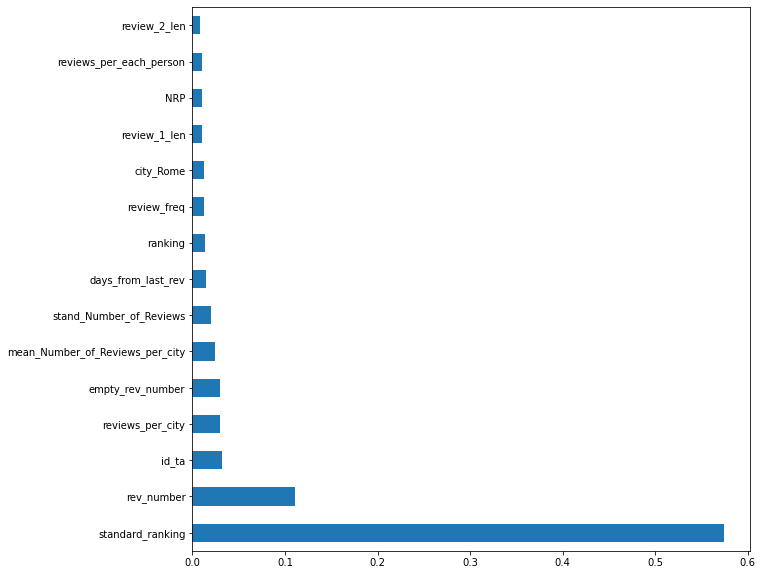

In [155]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [156]:
test_data.sample(10)

,ranking,price_range,rev_number,id_ta,rating,is_local_cuisine,empty_rev_number,empty_price,empty_reviews,chained_rest,dupl_id,standard_ranking,is_capital,population,country_gdp,purchasing_power,tourists,rest_per_pop,cuisine_style_number,most_common_cuisine,top_unique_cuisine,isMostPopCusine,isMultyCusine,veget_cuisine,pop_cuisine,local_cuisine,NRP,many_revs,mean_Number_of_Reviews_per_city,max_Number_of_Reviews_per_city,stand_Number_of_Reviews,reviews_per_each_person,reviews_per_city,days_from_last_rev,review_freq,no_recent_revs,very_seldom_revs,rev_m1,rev_m2,rev_y1,rev_y2,empty_rev1,empty_rev2,review_1_len,review_2_len,well,good,excellent,poor,bad,worse,best,but,friendly,nice,ok,great,lovely,city_Barcelona,city_Berlin,city_Lisbon,city_London,city_Madrid,city_Milan,city_Other,city_Paris,city_Prague,city_Rome
7699,-0.400920,-2.087731,-0.357539,-0.359547,0.0,-0.703048,-0.261488,-0.729321,-0.440132,0.287080,-0.038499,-0.764436,-1.777856,0.776197,-0.681007,0.313365,-0.277774,-0.668982,-0.891069,0.448329,-0.020004,-0.624259,-0.867208,-0.654093,-0.798280,-0.682970,-0.236563,-0.10748,0.198491,0.169609,-0.408252,-0.295610,0.198491,1.756205,1.959877,-0.136609,-0.172573,-1.829040,-2.202053,-0.873307,-1.811217,-0.682120,-1.598334,0.682079,-2.470830,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,-0.464994,-0.186347,3.70507,-0.239153,-0.184559,-0.409919,-0.287325,-0.238639,-0.751303,-0.373041,-0.194136,-0.233683
4714,-0.788212,0.286525,-0.352615,0.195248,0.0,1.422377,-0.261488,-0.729321,-0.440132,0.287080,-0.038499,-0.278004,0.562475,-0.948953,-0.126367,-0.725768,1.728588,0.052864,1.850143,0.448329,-0.020004,-0.624259,1.153126,1.528836,1.252694,1.464194,-0.049880,-0.10748,2.158538,0.169609,-0.819909,-0.043647,2.158538,-0.626379,-0.730829,-0.136609,-0.172573,0.995357,1.121881,0.209448,0.334876,-0.682120,0.625652,-1.981007,-0.330077,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,2.150565,-0.186347,-0.26990,-0.239153,-0.184559,-0.409919,-0.287325,-0.238639,1.331022,-0.373041,-0.194136,-0.233683
9909,2.267148,-2.087731,-0.505251,-0.261841,0.0,-0.703048,-0.261488,-0.729321,-0.440132,0.287080,-0.038499,0.833838,0.562475,1.930250,-0.126367,-0.131977,-0.946562,-0.521127,-0.891069,-2.230503,-0.020004,-0.624259,-0.867208,-0.654093,-0.798280,-0.682970,-0.251708,-0.10748,0.214984,0.169609,2.266982,-0.316051,0.214984,-0.742860,2.984908,-0.136609,-0.172573,1.277797,-0.207693,0.209448,-0.738170,-0.682120,-1.598334,1.481004,-2.265498,-0.082499,2.053673,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,-0.338311,-0.171092,-0.464994,-0.186347,-0.26990,-0.239153,-0.184559,2.439509,-0.287325,-0.238639,-0.751303,-0.373041,-0.194136,-0.233683
5355,-0.805509,0.286525,-0.323073,1.398722,0.0,-0.703048,-0.261488,-0.729321,-0.440132,0.287080,-0.038499,-1.111887,0.562475,-0.941259,-1.133384,1.649394,0.391013,1.376537,0.753658,0.448329,-0.020004,1.601899,1.153126,1.528836,1.252694,-0.682970,-0.028316,-0.10748,0.053840,0.169609,-0.812238,-0.014542,0.053840,-0.774628,-0.843883,-0.136609,-0.172573,-1.829040,1.454274,1.292204,0.334876,-0.682120,0.625652,1.880467,0.164413,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,3.900348,-0.202256,-0.195959,-0.338311,-0.171092,2.150565,-0.186347,-0.26990,-0.239153,5.418323,-0.409919,-0.287325,-0.238639,-0.751303,-0.373041,-0.194136,-0.233683
6086,0.616632,0.286525,-0.268743,0.133232,0.0,-0.703048,3.824265,1.371138,-0.440132,0.287080,-0.038499,1.459250,0.562475,0.164451,0.711506,-1.319558,-0.277774,-0.585190,-0.891069,-2.230503,-0.020004,-0.624259,-0.867208,-0.654093,1.252694,-0.682970,-0.215969,-0.10748,-1.147008,0.169609,0.628100,-0.267814,-1.147008,3.252820,-0.135406,-0.136609,-0.172573,0.995357,0.124701,-3.038818,0.334876,-0.682120,0.625652,0.282616,0.164266,-0.082499,-0.486932,-0.253942,-0.091039,-0.093791,-0.026086,-0.256387,-0.202256,-0.195959,2.955858,-0.171092,-0.464994,

In [157]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [158]:
test_data = test_data.drop(['rating'], axis=1)

In [159]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [160]:
predict_submission = list(map(round_rating_pred, predict_submission))

In [161]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!


## Iterations

### Ноутбук был честно склолнирован и после доработал, привожду комментарии автора:

MAE для разных вариантов:
* 0.429 - с удаление столбцов, содержащих тип данных object и щаменой None-значений на средние значения по столбцам

Вторая итерация: MAE = 0.214121
* добавлен Ranking - место ресторана среди ресторанов своего города (взят из исходного датасета, не был использован в первой итерации);
* добавлен Number of Reviews - количество отзывов, оставленных о ресторане;
* price_range_digit - ординальный признак, харктеризующий ценовой диапазон;
* dummy-переменные по каждоу городу;
* cuisine_style_number - количество кухонь, которые есть в ресторане;
* days_from_last_rev - переменная, характеризующая актуальность последнего оставленного отзыва;
* review_freq - переменная, харктеризующая частоту оставления отзывов о ресторане.

Третья итерация: MAE = 0.20881099999999997
* добавлен признак city_population - численность населения городов

Четвертая итерация: MAE = 0.20695149999999998
* добавлен признак country_gdp - валовый внутренний продукт страны per capita в соответствии с городов

Пятая итерация: MAE = 0.21191499999999996
* добавлены dummy-переменные для каждого типа кухни; точность модели снизилась - следует сделать вывод о том, что конкретный набор кухонь, представленных в ресторане, оказывает менее значимым для итоговой оценки, нежели, например, КОЛИЧЕСТВО представленных в ресторане кухонь

Шестая итерация: MAE = 0.208522
* добавлен признак is_capital - определяет города-столицы

Судьмая итерация: MAE = 0.20852300000000001
* добавлены признаки по наличию ключевых слов в отзывах (например, good, excellent, worse, etc)


8th: MAE = 0.20163499999999998
* средние по выборке заменены на групповые средние по городам

9th: MAE = 0.19437687499999998
* добавлены новые признаки - количество ресторанов на город, количество ресторанов на 1 человека, признаки-флаги по наличию в ресторанах самой популярной кухни и более чем одной кухни, взвешенное количество отзывов по городам
* возвращен в модель признак ID_TA

10th: MAE = 0.165
* обработаны все признаки
* произведена стандартизация признаков
* проводимые операции определены в функции для удобства воспроизводства кода

### Далее идут мои комментарии

- Сначала я решил не использовать бейзлайн и доработать учебный ноутбук. Сабмишшн из самостоятельного ноутбука выдал **MAE: 0.20829699999999998**
- Потом я взялся за бейзлайн
  - **MAE: 0.20194874999999998** (добавил страны)
  - **MAE: 0.20154624999999998** (добавил количество кухонь)
  - **MAE: 0.20153875** (добавил dummy с частотами кухонь)
  - **MAE: 0.201381875** (добавил итальянские в Риме)
  - **MAE: 0.20171937499999995** (отрефакторил, всё сломалось, долго восстанавливал)
  - **MAE: 0.20141187500000002** (вручную составил словарь национальных кухонь)
  - **MAE: 0.20112874999999997** (добавил сетевые рестораны)
  - **MAE: 0.20089875** (добавил отношение цены к средней по городу)
  - **MAE: 0.200280625** (добавил индекс покупательной способности)
  - **MAE: 0.20027875** (добавил туристическую привлекательность и немного порефакторил) - тут начинается громкий мат. MAE на паблике 0.68475!
- На этом шаге я пошёл читать выложенные работы других студентов, отобрал пять лучших из лучших, оказывается люди составили куда более интересные словари, чем я, хотя почему-то никто не использовал кода для чтения данных напрямую из инета (как было у меня)
- Склонировал наиболее читаемый (пусть и не с самым высоким рейтингом) ноутбук, отрефакторил, запустил и проанализировал выводы по каждой визуализации, где-то что-то подправил. Вроде неплохо. **MAE: 0.1645625** и **0.16815** на паблике